# 1. Import Data and libraries

In [1]:
import pandas as pd
import os
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import warnings
import time
from sklearn.feature_selection import SelectPercentile, chi2
from lightgbm import LGBMRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from IPython.core.display import display, HTML
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error
from catboost import CatBoostRegressor
from sklearn.dummy import DummyRegressor
from sklearn import tree

/var/folders/5m/tbwsb3vs6734vbbw653my9v00000gp/T/ipykernel_6319/3359146156.py:12: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
warnings.filterwarnings('ignore') #ignore errors
display(HTML("<style>.container { width:90% !important; }</style>")) # Make notebook wide

In [3]:
def read_data(pth1:str, pth2:str) -> pd.DataFrame:
    try: df = pd.read_csv(pth1, parse_dates= ['date'])
    except OSError: df = pd.read_csv(pth2, parse_dates= ['date'])
    return df

In [4]:
pth1 = "https://github.com/DmitrijUsachev/weather_forecast/blob/cd3c27c5034c9746c2950faee6885cf775881b02/london_weather.csv"
pth1 = pth1.replace("github.com", "raw.githubusercontent.com").replace("/blob/", "/")
pth2 = 'Documents/=КУРС/weather/london_weather.csv'

In [5]:
df = read_data(pth1, pth2) 

In [6]:
df.head()

,date,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth
0,1979-01-01,2.0,7.0,52.0,2.3,-4.1,-7.5,0.4,101900.0,9.0
1,1979-01-02,6.0,1.7,27.0,1.6,-2.6,-7.5,0.0,102530.0,8.0
2,1979-01-03,5.0,0.0,13.0,1.3,-2.8,-7.2,0.0,102050.0,4.0
3,1979-01-04,8.0,0.0,13.0,-0.3,-2.6,-6.5,0.0,100840.0,2.0
4,1979-01-05,6.0,2.0,29.0,5.6,-0.8,-1.4,0.0,102250.0,1.0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15341 entries, 0 to 15340
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              15341 non-null  datetime64[ns]
 1   cloud_cover       15322 non-null  float64       
 2   sunshine          15341 non-null  float64       
 3   global_radiation  15322 non-null  float64       
 4   max_temp          15335 non-null  float64       
 5   mean_temp         15305 non-null  float64       
 6   min_temp          15339 non-null  float64       
 7   precipitation     15335 non-null  float64       
 8   pressure          15337 non-null  float64       
 9   snow_depth        13900 non-null  float64       
dtypes: datetime64[ns](1), float64(9)
memory usage: 1.2 MB


In [8]:
df.describe()

,date,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth
count,15341,15322.000000,15341.000000,15322.000000,15335.000000,15305.000000,15339.000000,15335.000000,15337.000000,13900.000000
mean,2000-01-01 00:00:00,5.268242,4.350238,118.756951,15.388777,11.475511,7.559867,1.668634,101536.605594,0.037986
min,1979-01-01 00:00:00,0.000000,0.000000,8.000000,-6.200000,-7.600000,-11.800000,0.000000,95960.000000,0.000000
25%,1989-07-02 00:00:00,4.000000,0.500000,41.000000,10.500000,7.000000,3.500000,0.000000,100920.000000,0.000000
50%,2000-01-01 00:00:00,6.000000,3.500000,95.000000,15.000000,11.400000,7.800000,0.000000,101620.000000,0.000000
75%,2010-07-02 00:00:00,7.000000,7.200000,186.000000,20.300000,16.000000,11.800000,1.600000,102240.000000,0.000000
max,2020-12-31 00:00:00,9.000000,16.000000,402.000000,37.900000,29.000000,22.300000,61.800000,104820.000000,22.000000
std,NaN,2.070072,4.028339,88.898272,6.554754,5.729709,5.326756,3.738540,1049.722604,0.545633


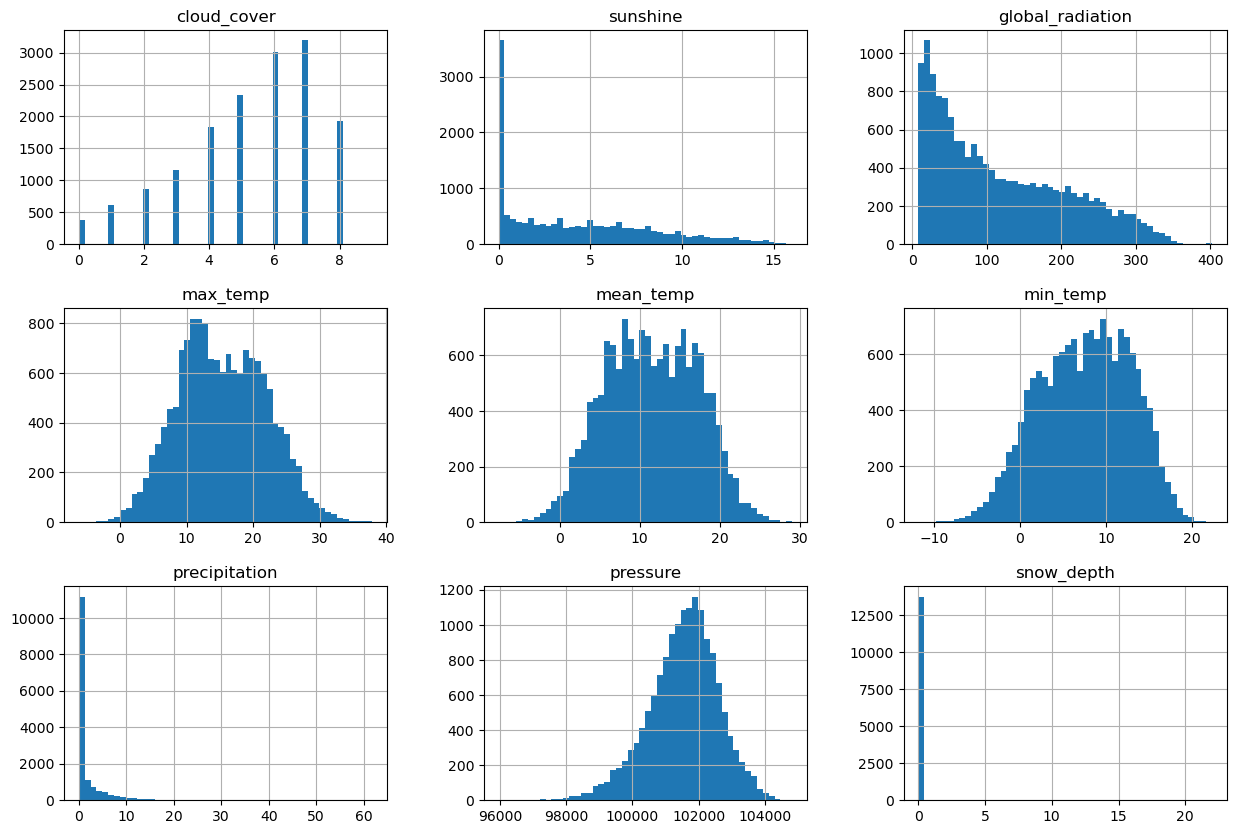

In [9]:
fig = plt.figure(figsize=(15,10))
ax = fig.gca()
df.drop(columns = 'date').hist(bins = 50, ax= ax);
plt.show()

In [10]:
df.duplicated().sum()

0

In [11]:
df.isna().sum()

date                   0
cloud_cover           19
sunshine               0
global_radiation      19
max_temp               6
mean_temp             36
min_temp               2
precipitation          6
pressure               4
snow_depth          1441
dtype: int64

In [12]:
df.sample(5)

,date,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth
3449,1988-06-11,7.0,0.0,81.0,19.5,13.3,10.3,0.0,101690.0,0.0
3558,1988-09-28,5.0,3.2,94.0,15.7,14.4,12.0,2.8,100460.0,0.0
4240,1990-08-11,7.0,10.1,249.0,29.4,21.0,14.5,0.0,101790.0,0.0
14057,2017-06-27,7.0,0.1,89.0,17.3,17.9,14.6,16.2,100670.0,0.0
8599,2002-07-18,6.0,6.3,218.0,24.2,19.1,14.8,0.0,102060.0,0.0


# 2. Fixing Nans

In order to understand what we can do with nans we need to build a corr matrix table

In [13]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,date,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth
date,1.000000,-0.107418,0.008303,0.006124,0.090610,0.099060,0.100521,0.008854,-0.014234,-0.045015
cloud_cover,-0.107418,1.000000,-0.738291,-0.485973,-0.212224,-0.110556,0.048838,0.235269,-0.241955,-0.001256
sunshine,0.008303,-0.738291,1.000000,0.852632,0.472182,0.396535,0.219082,-0.231636,0.226943,-0.034222
global_radiation,0.006124,-0.485973,0.852632,1.000000,0.690946,0.635432,0.478119,-0.162668,0.150078,-0.061781
max_temp,0.090610,-0.212224,0.472182,0.690946,1.000000,0.912200,0.810514,-0.071799,0.100455,-0.130594
mean_temp,0.099060,-0.110556,0.396535,0.635432,0.912200,1.000000,0.955593,-0.010462,0.004764,-0.154945
min_temp,0.100521,0.048838,0.219082,0.478119,0.810514,0.955593,1.000000,0.037233,-0.074274,-0.157882
precipitation,0.008854,0.235269,-0.231636,-0.162668,-0.071799,-0.010462,0.037233,1.000000,-0.349456,-0.001352
pressure,-0.014234,-0.241955,0.226943,0.150078,0.100455,0.004764,-0.074274,-0.349456,1.000000,-0.021229
snow_depth,-0.045015,-0.001256,-0.034222,-0.061781,-0.130594,-0.154945,-0.157882,-0.001352,-0.021229,1.000000


## Snow_depth

It logically to presume that there is no snow in summer.Therefore there is no snow depth

In [14]:
df.sample(5)

,date,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth
3432,1988-05-25,7.0,4.1,182.0,18.1,16.4,11.9,0.0,101460.0,0.0
11084,2009-05-07,6.0,0.4,92.0,16.0,12.8,9.5,0.2,101320.0,NaN
1889,1984-03-04,8.0,0.0,37.0,11.0,3.6,-0.1,0.0,102540.0,0.0
6657,1997-03-24,7.0,0.0,49.0,13.9,7.4,4.0,0.2,101110.0,0.0
14961,2019-12-18,5.0,1.2,23.0,13.6,6.4,0.8,9.0,100760.0,0.0


In [15]:
df.date.dt.month 

0         1
1         1
2         1
3         1
4         1
         ..
15336    12
15337    12
15338    12
15339    12
15340    12
Name: date, Length: 15341, dtype: int32

In [16]:
df.update(df[df.date.dt.month.isin(range(4,10))].snow_depth.fillna(0))

In [17]:
df.update(df[df.mean_temp >0].snow_depth.fillna(0))

In [18]:
df.isna().sum()

date                 0
cloud_cover         19
sunshine             0
global_radiation    19
max_temp             6
mean_temp           36
min_temp             2
precipitation        6
pressure             4
snow_depth           5
dtype: int64

In [19]:
df.sample(5)

,date,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth
6234,1996-01-26,6.0,1.1,31.0,2.5,-2.2,-3.2,0.1,101630.0,0.0
2664,1986-04-18,7.0,1.0,96.0,10.8,6.7,4.2,0.2,100540.0,0.0
6889,1997-11-11,4.0,4.3,58.0,11.3,8.0,3.6,0.0,99360.0,0.0
10205,2006-12-10,4.0,2.1,29.0,12.7,6.4,0.1,3.8,102290.0,0.0
13543,2016-01-30,6.0,3.5,51.0,13.4,7.7,7.3,0.4,101000.0,0.0


In [20]:
df.describe()

,date,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth
count,15341,15322.000000,15341.000000,15322.000000,15335.000000,15305.000000,15339.000000,15335.000000,15337.000000,15336.000000
mean,2000-01-01 00:00:00,5.268242,4.350238,118.756951,15.388777,11.475511,7.559867,1.668634,101536.605594,0.034429
min,1979-01-01 00:00:00,0.000000,0.000000,8.000000,-6.200000,-7.600000,-11.800000,0.000000,95960.000000,0.000000
25%,1989-07-02 00:00:00,4.000000,0.500000,41.000000,10.500000,7.000000,3.500000,0.000000,100920.000000,0.000000
50%,2000-01-01 00:00:00,6.000000,3.500000,95.000000,15.000000,11.400000,7.800000,0.000000,101620.000000,0.000000
75%,2010-07-02 00:00:00,7.000000,7.200000,186.000000,20.300000,16.000000,11.800000,1.600000,102240.000000,0.000000
max,2020-12-31 00:00:00,9.000000,16.000000,402.000000,37.900000,29.000000,22.300000,61.800000,104820.000000,22.000000
std,NaN,2.070072,4.028339,88.898272,6.554754,5.729709,5.326756,3.738540,1049.722604,0.519576


In [21]:
df.snow_depth.dropna()

0        9.0
1        8.0
2        4.0
3        2.0
4        1.0
        ... 
15335    0.0
15336    0.0
15337    0.0
15338    0.0
15339    0.0
Name: snow_depth, Length: 15336, dtype: float64

In [22]:
df.value_counts()

date        cloud_cover  sunshine  global_radiation  max_temp  mean_temp  min_temp  precipitation  pressure  snow_depth
1979-01-01  2.0          7.0       52.0              2.3       -4.1       -7.5      0.4            101900.0  9.0           1
2006-12-24  8.0          0.0       12.0              7.0        4.6        2.2      0.0            103830.0  0.0           1
2006-12-11  7.0          0.0       12.0              12.5       7.2        1.9      1.8            101350.0  0.0           1
2006-12-12  4.0          1.6       26.0              11.7       7.8        3.8      0.2            101850.0  0.0           1
2006-12-13  7.0          0.0       12.0              12.9       9.6        6.4      0.0            102100.0  0.0           1
                                                                                                                          ..
1992-12-23  2.0          2.5       30.0              4.0        1.6       -0.7      0.0            103210.0  0.0           1
1992-

In [23]:
df.isna().sum()

date                 0
cloud_cover         19
sunshine             0
global_radiation    19
max_temp             6
mean_temp           36
min_temp             2
precipitation        6
pressure             4
snow_depth           5
dtype: int64

## Mean temperature

it is easy to calculate mean temperature using min and max

In [24]:
def fillna_min_max(df:pd.DataFrame) -> pd.DataFrame:
    counter = 0
    for i,row in df.iterrows():
        if pd.isna(row.mean_temp) == True and pd.isna(row.max_temp) == False and pd.isna(row.min_temp) == False:
            df.loc[i,'mean_temp'] = (row.max_temp - row.min_temp)/2
            counter += 1
    print(counter)
    return df

In [25]:
df = fillna_min_max(df)

29


In [26]:
df.isna().sum()

date                 0
cloud_cover         19
sunshine             0
global_radiation    19
max_temp             6
mean_temp            7
min_temp             2
precipitation        6
pressure             4
snow_depth           5
dtype: int64

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15341 entries, 0 to 15340
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              15341 non-null  datetime64[ns]
 1   cloud_cover       15322 non-null  float64       
 2   sunshine          15341 non-null  float64       
 3   global_radiation  15322 non-null  float64       
 4   max_temp          15335 non-null  float64       
 5   mean_temp         15334 non-null  float64       
 6   min_temp          15339 non-null  float64       
 7   precipitation     15335 non-null  float64       
 8   pressure          15337 non-null  float64       
 9   snow_depth        15336 non-null  float64       
dtypes: datetime64[ns](1), float64(9)
memory usage: 1.2 MB


Other nans in mean_temperature can be removed. We cannot do anything to fill those nans

In [28]:
df = df[pd.isna(df.mean_temp) == False]

In [29]:
df.isna().sum()

date                 0
cloud_cover         19
sunshine             0
global_radiation    19
max_temp             0
mean_temp            0
min_temp             0
precipitation        2
pressure             4
snow_depth           2
dtype: int64

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15334 entries, 0 to 15340
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              15334 non-null  datetime64[ns]
 1   cloud_cover       15315 non-null  float64       
 2   sunshine          15334 non-null  float64       
 3   global_radiation  15315 non-null  float64       
 4   max_temp          15334 non-null  float64       
 5   mean_temp         15334 non-null  float64       
 6   min_temp          15334 non-null  float64       
 7   precipitation     15332 non-null  float64       
 8   pressure          15330 non-null  float64       
 9   snow_depth        15332 non-null  float64       
dtypes: datetime64[ns](1), float64(9)
memory usage: 1.3 MB


## Cloud_cover and Global radiation

Each of those features has a strong correlation with a sunshine.
Let's devide the level of sunshine to categories: cloudy, middle, sunny 

In [31]:
df.sunshine.describe()

count    15334.000000
mean         4.350678
std          4.028578
min          0.000000
25%          0.500000
50%          3.500000
75%          7.200000
max         16.000000
Name: sunshine, dtype: float64

In [32]:
class Preprocessor():
    def level_of_sunshine(self, df: pd.DataFrame) -> pd.DataFrame:
        for i, row in df.iterrows():
            if pd.isna(row.sunshine) == False:
                if row.sunshine < 0.5: df.loc[i,'level_of_sunshine'] = 'cloudy'
                if 0.5 <= row.sunshine >= 3.5: df.loc[i,'level_of_sunshine'] = 'middle'
                if row.sunshine > 3.5: df.loc[i,'level_of_sunshine'] = 'sunny'
        return df
        
    def calculate_median_cloud_cover(self, df: pd.DataFrame) -> pd.DataFrame:
        groupped = df.groupby('level_of_sunshine').agg('median')
        for i, row in df.iterrows():
            if pd.isna(row.cloud_cover) == True:
                if row.level_of_sunshine == 'cloudy':  
                    df.loc[i, 'cloud_cover'] = groupped[groupped.index == 'cloudy'].cloud_cover.values[0]
                elif row.level_of_sunshine == 'middle':  
                    df.loc[i, 'cloud_cover'] = groupped[groupped.index == 'middle'].cloud_cover.values[0]
                elif row.level_of_sunshine == 'sunny':  
                    df.loc[i, 'cloud_cover'] = groupped[groupped.index == 'sunny'].cloud_cover.values[0]
        return df

    def calculate_median_rad(self, df: pd.DataFrame) -> pd.DataFrame:
        groupped = df.groupby('level_of_sunshine').agg('median')
        for i, row in df.iterrows():
            if pd.isna(row.global_radiation) == True:
                if row.level_of_sunshine == 'cloudy':  
                    df.loc[i, 'global_radiation'] = groupped[groupped.index == 'cloudy'].global_radiation.values[0]
                elif row.level_of_sunshine == 'middle':  
                    df.loc[i, 'global_radiation'] = groupped[groupped.index == 'middle'].global_radiation.values[0]
                elif row.level_of_sunshine == 'sunny':  
                    df.loc[i, 'global_radiation'] = groupped[groupped.index == 'sunny'].global_radiation.values[0]
        return df
        
    def preprocess_nans(self, df: pd.DataFrame) -> pd.DataFrame: #do all functions one by one
        df = self.level_of_sunshine(df)
        df = self.calculate_median_cloud_cover(df)
        df = self.calculate_median_rad(df)
        return df

In [33]:
preprocessor1 = Preprocessor()

In [34]:
df = preprocessor1.preprocess_nans(df)

In [35]:
df.isna().sum()

date                    0
cloud_cover             3
sunshine                0
global_radiation        0
max_temp                0
mean_temp               0
min_temp                0
precipitation           2
pressure                4
snow_depth              2
level_of_sunshine    3749
dtype: int64

# 3.Analysis of dataset

In [36]:
def plot(df:pd.DataFrame):
    fig = plt.figure(figsize=(15,10))
    ax = fig.gca()
    df.drop(columns = 'date').hist(bins = 50, ax= ax);
    plt.show()
pass

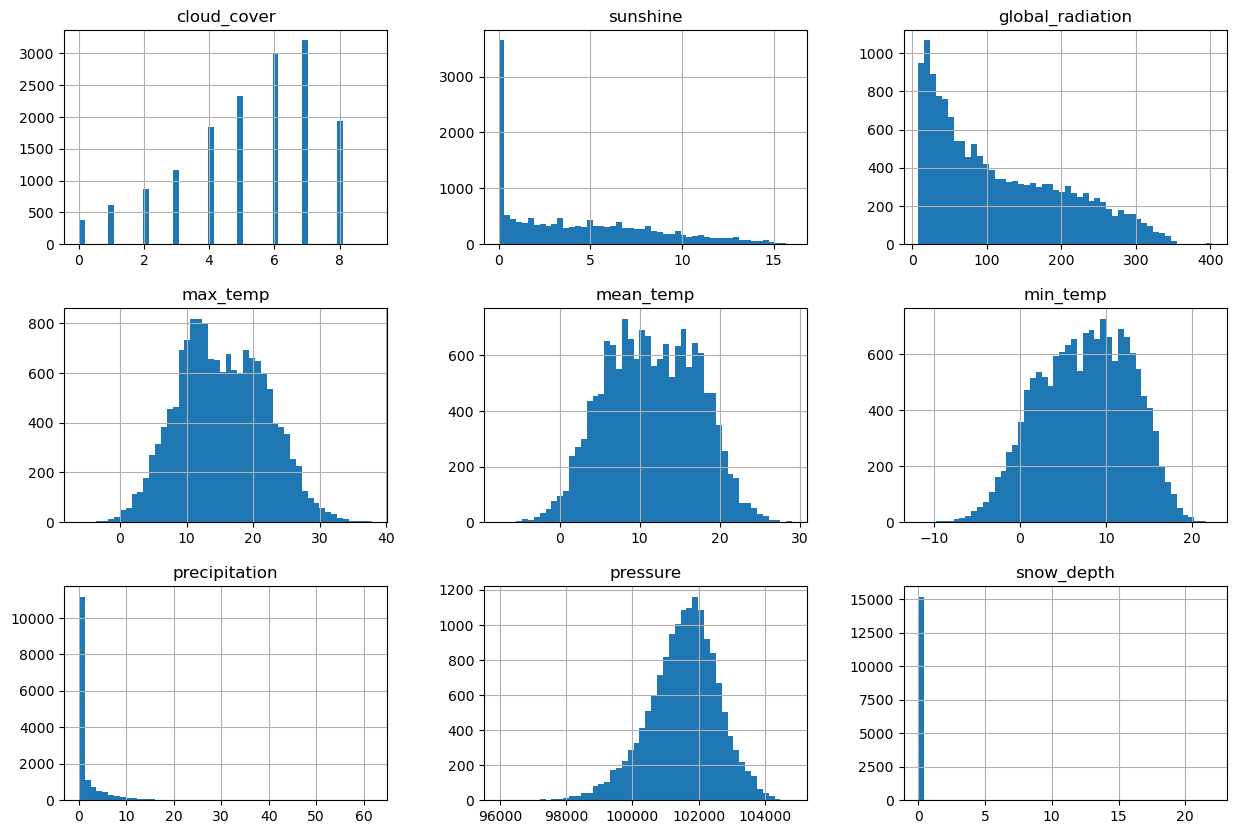

In [37]:
plot(df)

it looks like zeros in shunshine and preci and precipations features means nothing

In [38]:
df = df[(df.sunshine != 0) & (df.precipitation != 0)]

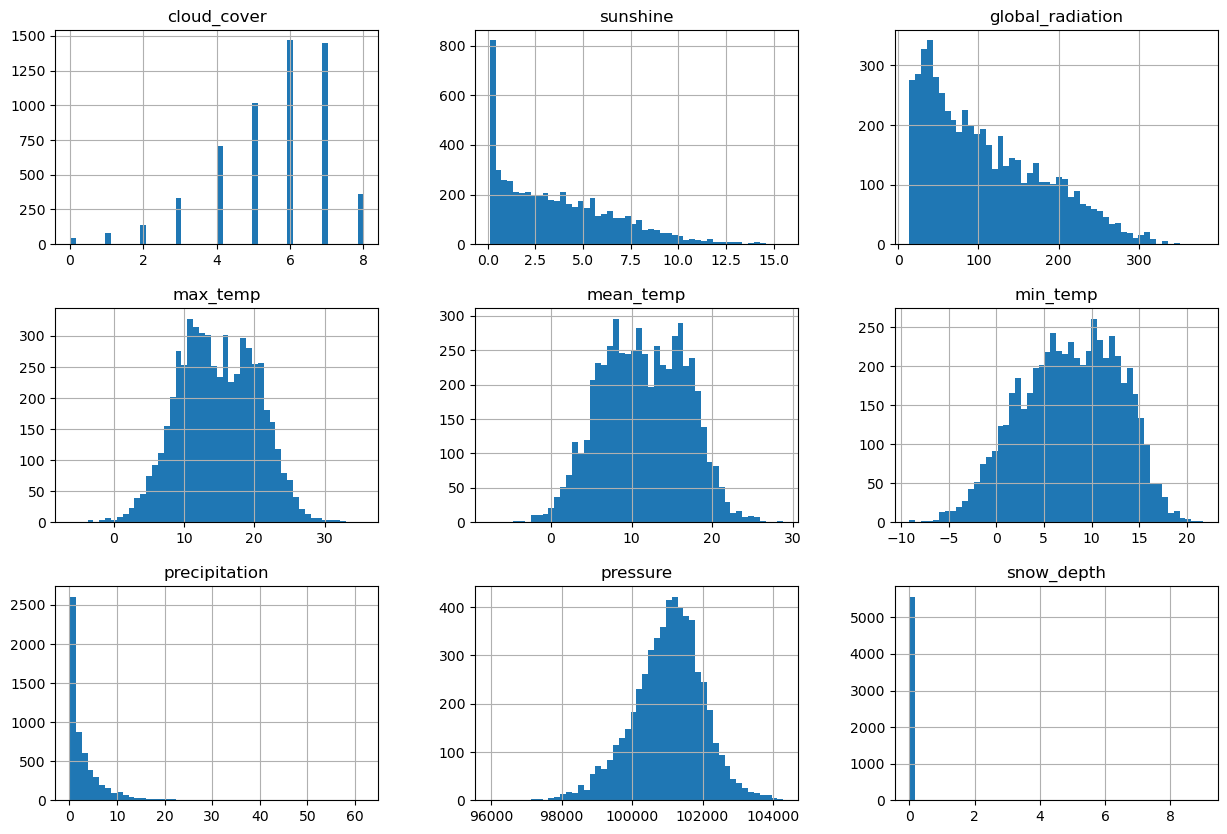

In [39]:
plot(df)

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5606 entries, 0 to 15337
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   date               5606 non-null   datetime64[ns]
 1   cloud_cover        5605 non-null   float64       
 2   sunshine           5606 non-null   float64       
 3   global_radiation   5606 non-null   float64       
 4   max_temp           5606 non-null   float64       
 5   mean_temp          5606 non-null   float64       
 6   min_temp           5606 non-null   float64       
 7   precipitation      5604 non-null   float64       
 8   pressure           5604 non-null   float64       
 9   snow_depth         5605 non-null   float64       
 10  level_of_sunshine  3382 non-null   object        
dtypes: datetime64[ns](1), float64(9), object(1)
memory usage: 525.6+ KB


# 4. Make model 

In [41]:
df.date = df.date.map(lambda x : dt.datetime.toordinal(x)) #regression models unable to work with date 
df = df.drop(columns = ['max_temp', 'min_temp', 'level_of_sunshine'])

In [42]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,date,cloud_cover,sunshine,global_radiation,mean_temp,precipitation,pressure,snow_depth
date,1.000000,-0.145453,-0.023232,-0.046197,0.063669,-0.007623,0.022953,-0.034380
cloud_cover,-0.145453,1.000000,-0.583860,-0.204664,0.143991,0.153901,-0.179814,-0.029384
sunshine,-0.023232,-0.583860,1.000000,0.762780,0.204889,-0.097750,0.144509,-0.008893
global_radiation,-0.046197,-0.204664,0.762780,1.000000,0.565335,-0.010655,0.123329,-0.054707
mean_temp,0.063669,0.143991,0.204889,0.565335,1.000000,0.106391,0.032771,-0.147523
precipitation,-0.007623,0.153901,-0.097750,-0.010655,0.106391,1.000000,-0.206351,-0.020237
pressure,0.022953,-0.179814,0.144509,0.123329,0.032771,-0.206351,1.000000,0.006532
snow_depth,-0.034380,-0.029384,-0.008893,-0.054707,-0.147523,-0.020237,0.006532,1.000000


In [43]:
features = df.drop(columns = ['mean_temp'])
target = df.mean_temp

In [44]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.25, random_state = 42)

In [45]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(4204, 7)
(1402, 7)
(4204,)
(1402,)


In [46]:
numeric_features = X_train.columns

params = {}
model = LinearRegression()
numeric_transformer = Pipeline(
    steps=[("scaler", StandardScaler()), 
           ('imputer', SimpleImputer(missing_values= np.nan, strategy='mean'))] )


preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
    ]
)

In [47]:
pipeline = make_pipeline(preprocessor, model)

In [48]:
gs = GridSearchCV(pipeline, params, cv=5, return_train_score=True, scoring='neg_mean_absolute_error')

In [49]:
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler()),
                                                                                         ('imputer',
                                                                                          SimpleImputer())]),
                                                                         Index(['date', 'cloud_cover', 'sunshine', 'global_radiation', 'precipitation',
       'pressure', 'snow_depth'],
      dtype='object'))])),
                                       ('linearregression',
                                        LinearRegression())]),
             param_grid={}, return_train_score=True,
             scoring='neg_mean_absolute_error')

In [50]:
abs(gs.best_score_)

3.143724078806339

In [51]:
model = CatBoostRegressor(random_state= 42)
pipeline = make_pipeline(preprocessor,model)
params = {'catboostregressor__iterations': [2, 3, 4, 5,6,7,8,9,10], 
          'catboostregressor__learning_rate': [1,0.1, 0.01, 0.001,0.0001],
          'catboostregressor__depth': [2, 3, 4, 5, 6, 7, 8]}
    
gs = GridSearchCV(pipeline, params, cv=5, return_train_score=True, scoring='neg_mean_absolute_error');
gs.fit(X_train, y_train)

0:	learn: 4.3912257	total: 53.8ms	remaining: 53.8ms
1:	learn: 4.2341024	total: 55.3ms	remaining: 0us
0:	learn: 4.3646977	total: 948us	remaining: 948us
1:	learn: 4.1539210	total: 1.73ms	remaining: 0us
0:	learn: 4.3789074	total: 913us	remaining: 913us
1:	learn: 4.2228024	total: 1.56ms	remaining: 0us
0:	learn: 4.3667874	total: 1.13ms	remaining: 1.13ms
1:	learn: 4.1984310	total: 1.77ms	remaining: 0us
0:	learn: 4.3923244	total: 1.04ms	remaining: 1.04ms
1:	learn: 4.1992500	total: 2.42ms	remaining: 0us
0:	learn: 5.1334209	total: 1.7ms	remaining: 1.7ms
1:	learn: 4.9885672	total: 2.89ms	remaining: 0us
0:	learn: 5.0776372	total: 926us	remaining: 926us
1:	learn: 4.9386794	total: 2.21ms	remaining: 0us
0:	learn: 5.1369735	total: 857us	remaining: 857us
1:	learn: 4.9879947	total: 1.55ms	remaining: 0us
0:	learn: 5.0882150	total: 1.21ms	remaining: 1.21ms
1:	learn: 4.9518995	total: 2.43ms	remaining: 0us
0:	learn: 5.1111267	total: 985us	remaining: 985us
1:	learn: 4.9733030	total: 2.06ms	remaining: 0us
0:

0:	learn: 5.2902698	total: 1.26ms	remaining: 3.77ms
1:	learn: 5.2886018	total: 2.33ms	remaining: 2.33ms
2:	learn: 5.2869316	total: 3.41ms	remaining: 1.14ms
3:	learn: 5.2853014	total: 4.52ms	remaining: 0us
0:	learn: 5.2286968	total: 1.37ms	remaining: 4.1ms
1:	learn: 5.2270319	total: 2.87ms	remaining: 2.87ms
2:	learn: 5.2254862	total: 3.91ms	remaining: 1.3ms
3:	learn: 5.2238843	total: 5.8ms	remaining: 0us
0:	learn: 5.2968739	total: 1.29ms	remaining: 3.88ms
1:	learn: 5.2951444	total: 2.24ms	remaining: 2.24ms
2:	learn: 5.2934405	total: 3.35ms	remaining: 1.12ms
3:	learn: 5.2917514	total: 4.07ms	remaining: 0us
0:	learn: 5.2409515	total: 1.02ms	remaining: 3.07ms
1:	learn: 5.2393105	total: 1.8ms	remaining: 1.8ms
2:	learn: 5.2376508	total: 2.44ms	remaining: 813us
3:	learn: 5.2359915	total: 3.09ms	remaining: 0us
0:	learn: 5.2634087	total: 793us	remaining: 2.38ms
1:	learn: 5.2617537	total: 1.47ms	remaining: 1.47ms
2:	learn: 5.2601079	total: 2.18ms	remaining: 727us
3:	learn: 5.2584923	total: 2.82m

0:	learn: 4.3789074	total: 948us	remaining: 4.74ms
1:	learn: 4.2228024	total: 2.06ms	remaining: 4.13ms
2:	learn: 4.1132643	total: 2.87ms	remaining: 2.87ms
3:	learn: 4.0501881	total: 3.65ms	remaining: 1.82ms
4:	learn: 3.9839627	total: 5.38ms	remaining: 1.07ms
5:	learn: 3.9072807	total: 6.28ms	remaining: 0us
0:	learn: 4.3667874	total: 732us	remaining: 3.66ms
1:	learn: 4.1984310	total: 1.41ms	remaining: 2.82ms
2:	learn: 4.0571673	total: 2.04ms	remaining: 2.04ms
3:	learn: 4.0004248	total: 2.67ms	remaining: 1.33ms
4:	learn: 3.9476401	total: 3.35ms	remaining: 669us
5:	learn: 3.8553624	total: 4.01ms	remaining: 0us
0:	learn: 4.3923244	total: 756us	remaining: 3.78ms
1:	learn: 4.1992500	total: 1.44ms	remaining: 2.89ms
2:	learn: 4.1067265	total: 2.07ms	remaining: 2.07ms
3:	learn: 4.0245413	total: 2.74ms	remaining: 1.37ms
4:	learn: 3.9756784	total: 3.41ms	remaining: 682us
5:	learn: 3.9256828	total: 4.07ms	remaining: 0us
0:	learn: 5.1334209	total: 755us	remaining: 3.78ms
1:	learn: 4.9885672	total: 

0:	learn: 5.0776372	total: 1.16ms	remaining: 6.98ms
1:	learn: 4.9386794	total: 2.5ms	remaining: 6.26ms
2:	learn: 4.8246702	total: 3.49ms	remaining: 4.65ms
3:	learn: 4.7275085	total: 4.84ms	remaining: 3.63ms
4:	learn: 4.6342871	total: 5.96ms	remaining: 2.38ms
5:	learn: 4.5602049	total: 6.94ms	remaining: 1.16ms
6:	learn: 4.5033578	total: 8.23ms	remaining: 0us
0:	learn: 5.1369735	total: 1.24ms	remaining: 7.44ms
1:	learn: 4.9879947	total: 2.77ms	remaining: 6.93ms
2:	learn: 4.8719376	total: 3.94ms	remaining: 5.25ms
3:	learn: 4.7701415	total: 4.76ms	remaining: 3.57ms
4:	learn: 4.6749562	total: 7.07ms	remaining: 2.83ms
5:	learn: 4.5975967	total: 8.21ms	remaining: 1.37ms
6:	learn: 4.5313196	total: 9.27ms	remaining: 0us
0:	learn: 5.0882150	total: 857us	remaining: 5.14ms
1:	learn: 4.9518995	total: 1.59ms	remaining: 3.97ms
2:	learn: 4.8364813	total: 2.39ms	remaining: 3.19ms
3:	learn: 4.7384489	total: 3.11ms	remaining: 2.33ms
4:	learn: 4.6463642	total: 3.81ms	remaining: 1.53ms
5:	learn: 4.5735584	

0:	learn: 4.3923244	total: 1.14ms	remaining: 7.96ms
1:	learn: 4.1992500	total: 2.43ms	remaining: 7.29ms
2:	learn: 4.1067265	total: 3.46ms	remaining: 5.77ms
3:	learn: 4.0245413	total: 4.39ms	remaining: 4.39ms
4:	learn: 3.9756784	total: 5.42ms	remaining: 3.25ms
5:	learn: 3.9256828	total: 6.57ms	remaining: 2.19ms
6:	learn: 3.8881055	total: 8.04ms	remaining: 1.15ms
7:	learn: 3.8568347	total: 9.03ms	remaining: 0us
0:	learn: 5.1334209	total: 777us	remaining: 5.44ms
1:	learn: 4.9885672	total: 1.46ms	remaining: 4.38ms
2:	learn: 4.8767154	total: 2.1ms	remaining: 3.5ms
3:	learn: 4.7785783	total: 2.79ms	remaining: 2.79ms
4:	learn: 4.6839956	total: 3.43ms	remaining: 2.06ms
5:	learn: 4.6088187	total: 4.32ms	remaining: 1.44ms
6:	learn: 4.5440089	total: 5.4ms	remaining: 771us
7:	learn: 4.4858656	total: 6.76ms	remaining: 0us
0:	learn: 5.0776372	total: 1.27ms	remaining: 8.92ms
1:	learn: 4.9386794	total: 1.98ms	remaining: 5.93ms
2:	learn: 4.8246702	total: 2.68ms	remaining: 4.47ms
3:	learn: 4.7275085	tot

0:	learn: 5.2648444	total: 764us	remaining: 5.35ms
1:	learn: 5.2646786	total: 2.24ms	remaining: 6.72ms
2:	learn: 5.2645136	total: 3.69ms	remaining: 6.15ms
3:	learn: 5.2643513	total: 4.57ms	remaining: 4.57ms
4:	learn: 5.2641884	total: 5.28ms	remaining: 3.17ms
5:	learn: 5.2640203	total: 5.92ms	remaining: 1.97ms
6:	learn: 5.2638686	total: 6.65ms	remaining: 950us
7:	learn: 5.2637139	total: 7.39ms	remaining: 0us
0:	learn: 4.3912257	total: 833us	remaining: 6.67ms
1:	learn: 4.2341024	total: 1.46ms	remaining: 5.12ms
2:	learn: 4.0750367	total: 2.08ms	remaining: 4.15ms
3:	learn: 4.0093448	total: 2.75ms	remaining: 3.44ms
4:	learn: 3.9368161	total: 3.44ms	remaining: 2.75ms
5:	learn: 3.9026323	total: 4.37ms	remaining: 2.19ms
6:	learn: 3.8429160	total: 5.62ms	remaining: 1.61ms
7:	learn: 3.8237826	total: 6.64ms	remaining: 829us
8:	learn: 3.8052644	total: 7.66ms	remaining: 0us
0:	learn: 4.3646977	total: 828us	remaining: 6.63ms
1:	learn: 4.1539210	total: 1.52ms	remaining: 5.33ms
2:	learn: 4.0747907	tot

0:	learn: 5.2301210	total: 1.11ms	remaining: 8.9ms
1:	learn: 5.2299543	total: 2.34ms	remaining: 8.18ms
2:	learn: 5.2297993	total: 3.33ms	remaining: 6.65ms
3:	learn: 5.2296385	total: 4.28ms	remaining: 5.35ms
4:	learn: 5.2294770	total: 5.24ms	remaining: 4.2ms
5:	learn: 5.2293093	total: 6.25ms	remaining: 3.12ms
6:	learn: 5.2291616	total: 7.46ms	remaining: 2.13ms
7:	learn: 5.2290054	total: 8.55ms	remaining: 1.07ms
8:	learn: 5.2288349	total: 9.54ms	remaining: 0us
0:	learn: 5.2983805	total: 833us	remaining: 6.67ms
1:	learn: 5.2982073	total: 1.51ms	remaining: 5.3ms
2:	learn: 5.2980364	total: 2.19ms	remaining: 4.38ms
3:	learn: 5.2978667	total: 2.83ms	remaining: 3.54ms
4:	learn: 5.2976962	total: 3.52ms	remaining: 2.81ms
5:	learn: 5.2975226	total: 4.22ms	remaining: 2.11ms
6:	learn: 5.2973606	total: 4.93ms	remaining: 1.41ms
7:	learn: 5.2971970	total: 5.58ms	remaining: 697us
8:	learn: 5.2970213	total: 6.24ms	remaining: 0us
0:	learn: 5.2423913	total: 770us	remaining: 6.17ms
1:	learn: 5.2422269	tota

0:	learn: 5.2968739	total: 1.14ms	remaining: 10.3ms
1:	learn: 5.2951444	total: 2.91ms	remaining: 11.6ms
2:	learn: 5.2934405	total: 4ms	remaining: 9.34ms
3:	learn: 5.2917514	total: 5.26ms	remaining: 7.89ms
4:	learn: 5.2900560	total: 6.3ms	remaining: 6.3ms
5:	learn: 5.2883310	total: 7.4ms	remaining: 4.93ms
6:	learn: 5.2867243	total: 8.55ms	remaining: 3.66ms
7:	learn: 5.2851033	total: 9.4ms	remaining: 2.35ms
8:	learn: 5.2833647	total: 10ms	remaining: 1.11ms
9:	learn: 5.2817811	total: 11.1ms	remaining: 0us
0:	learn: 5.2409515	total: 900us	remaining: 8.1ms
1:	learn: 5.2393105	total: 1.65ms	remaining: 6.58ms
2:	learn: 5.2376508	total: 2.35ms	remaining: 5.48ms
3:	learn: 5.2359915	total: 3.04ms	remaining: 4.55ms
4:	learn: 5.2343013	total: 3.8ms	remaining: 3.8ms
5:	learn: 5.2326441	total: 4.48ms	remaining: 2.99ms
6:	learn: 5.2311184	total: 5.3ms	remaining: 2.27ms
7:	learn: 5.2295825	total: 6.05ms	remaining: 1.51ms
8:	learn: 5.2278984	total: 6.77ms	remaining: 752us
9:	learn: 5.2264146	total: 7.4

0:	learn: 5.2135872	total: 1.54ms	remaining: 3.08ms
1:	learn: 5.1951300	total: 2.89ms	remaining: 1.45ms
2:	learn: 5.1781109	total: 4.57ms	remaining: 0us
0:	learn: 5.2809953	total: 1.1ms	remaining: 2.2ms
1:	learn: 5.2624098	total: 1.97ms	remaining: 982us
2:	learn: 5.2447242	total: 2.79ms	remaining: 0us
0:	learn: 5.2257781	total: 979us	remaining: 1.96ms
1:	learn: 5.2083126	total: 1.97ms	remaining: 983us
2:	learn: 5.1910394	total: 3.03ms	remaining: 0us
0:	learn: 5.2482820	total: 986us	remaining: 1.97ms
1:	learn: 5.2296127	total: 1.82ms	remaining: 909us
2:	learn: 5.2107005	total: 2.64ms	remaining: 0us
0:	learn: 5.2901901	total: 951us	remaining: 1.9ms
1:	learn: 5.2882083	total: 2.1ms	remaining: 1.05ms
2:	learn: 5.2864208	total: 2.93ms	remaining: 0us
0:	learn: 5.2286051	total: 967us	remaining: 1.93ms
1:	learn: 5.2268208	total: 1.88ms	remaining: 940us
2:	learn: 5.2250696	total: 2.75ms	remaining: 0us
0:	learn: 5.2967874	total: 1.19ms	remaining: 2.37ms
1:	learn: 5.2949132	total: 3.13ms	remainin

0:	learn: 5.0800874	total: 1.02ms	remaining: 4.09ms
1:	learn: 4.9141801	total: 2.17ms	remaining: 3.26ms
2:	learn: 4.7871120	total: 3.08ms	remaining: 2.05ms
3:	learn: 4.6803986	total: 3.92ms	remaining: 979us
4:	learn: 4.5918644	total: 4.93ms	remaining: 0us
0:	learn: 5.1030534	total: 948us	remaining: 3.79ms
1:	learn: 4.9378196	total: 1.85ms	remaining: 2.77ms
2:	learn: 4.8127697	total: 2.8ms	remaining: 1.87ms
3:	learn: 4.6950468	total: 3.64ms	remaining: 909us
4:	learn: 4.6077705	total: 4.55ms	remaining: 0us
0:	learn: 5.2747420	total: 1ms	remaining: 4ms
1:	learn: 5.2558621	total: 1.88ms	remaining: 2.81ms
2:	learn: 5.2384970	total: 2.68ms	remaining: 1.78ms
3:	learn: 5.2201658	total: 3.54ms	remaining: 886us
4:	learn: 5.2044046	total: 4.38ms	remaining: 0us
0:	learn: 5.2135872	total: 1.3ms	remaining: 5.21ms
1:	learn: 5.1951300	total: 2.21ms	remaining: 3.32ms
2:	learn: 5.1781109	total: 3.09ms	remaining: 2.06ms
3:	learn: 5.1608384	total: 3.92ms	remaining: 979us
4:	learn: 5.1461356	total: 4.71ms	

0:	learn: 5.2257781	total: 1.47ms	remaining: 7.36ms
1:	learn: 5.2083126	total: 3.14ms	remaining: 6.29ms
2:	learn: 5.1910394	total: 4.54ms	remaining: 4.54ms
3:	learn: 5.1740742	total: 6.79ms	remaining: 3.39ms
4:	learn: 5.1588828	total: 8.31ms	remaining: 1.66ms
5:	learn: 5.1420197	total: 11.3ms	remaining: 0us
0:	learn: 5.2482820	total: 897us	remaining: 4.49ms
1:	learn: 5.2296127	total: 1.83ms	remaining: 3.65ms
2:	learn: 5.2107005	total: 2.8ms	remaining: 2.8ms
3:	learn: 5.1925374	total: 3.71ms	remaining: 1.86ms
4:	learn: 5.1774351	total: 4.69ms	remaining: 938us
5:	learn: 5.1594121	total: 5.67ms	remaining: 0us
0:	learn: 5.2901901	total: 958us	remaining: 4.79ms
1:	learn: 5.2882083	total: 1.8ms	remaining: 3.61ms
2:	learn: 5.2864208	total: 2.61ms	remaining: 2.61ms
3:	learn: 5.2845126	total: 3.48ms	remaining: 1.74ms
4:	learn: 5.2828563	total: 4.33ms	remaining: 866us
5:	learn: 5.2810606	total: 5.19ms	remaining: 0us
0:	learn: 5.2286051	total: 982us	remaining: 4.91ms
1:	learn: 5.2268208	total: 1.

0:	learn: 5.2286051	total: 1.57ms	remaining: 9.45ms
1:	learn: 5.2268208	total: 3.1ms	remaining: 7.76ms
2:	learn: 5.2250696	total: 4.18ms	remaining: 5.57ms
3:	learn: 5.2231531	total: 5.92ms	remaining: 4.44ms
4:	learn: 5.2215015	total: 7.43ms	remaining: 2.97ms
5:	learn: 5.2195738	total: 8.7ms	remaining: 1.45ms
6:	learn: 5.2178233	total: 9.76ms	remaining: 0us
0:	learn: 5.2967874	total: 1.03ms	remaining: 6.19ms
1:	learn: 5.2949132	total: 1.98ms	remaining: 4.96ms
2:	learn: 5.2929058	total: 2.96ms	remaining: 3.95ms
3:	learn: 5.2909463	total: 3.94ms	remaining: 2.96ms
4:	learn: 5.2891321	total: 4.89ms	remaining: 1.96ms
5:	learn: 5.2872875	total: 5.71ms	remaining: 951us
6:	learn: 5.2854677	total: 6.74ms	remaining: 0us
0:	learn: 5.2408689	total: 1.02ms	remaining: 6.13ms
1:	learn: 5.2389141	total: 2.03ms	remaining: 5.07ms
2:	learn: 5.2371365	total: 2.98ms	remaining: 3.97ms
3:	learn: 5.2353666	total: 3.95ms	remaining: 2.96ms
4:	learn: 5.2336480	total: 4.86ms	remaining: 1.94ms
5:	learn: 5.2318491	t

0:	learn: 5.2408689	total: 1.07ms	remaining: 7.47ms
1:	learn: 5.2389141	total: 2.15ms	remaining: 6.44ms
2:	learn: 5.2371365	total: 3.17ms	remaining: 5.28ms
3:	learn: 5.2353666	total: 4.28ms	remaining: 4.28ms
4:	learn: 5.2336480	total: 5.24ms	remaining: 3.14ms
5:	learn: 5.2318491	total: 6.37ms	remaining: 2.12ms
6:	learn: 5.2300764	total: 7.27ms	remaining: 1.04ms
7:	learn: 5.2283778	total: 8.44ms	remaining: 0us
0:	learn: 5.2633267	total: 1.02ms	remaining: 7.15ms
1:	learn: 5.2613765	total: 1.91ms	remaining: 5.72ms
2:	learn: 5.2596239	total: 2.73ms	remaining: 4.55ms
3:	learn: 5.2577297	total: 3.69ms	remaining: 3.69ms
4:	learn: 5.2561395	total: 4.52ms	remaining: 2.71ms
5:	learn: 5.2543363	total: 5.41ms	remaining: 1.8ms
6:	learn: 5.2525969	total: 6.26ms	remaining: 894us
7:	learn: 5.2509128	total: 7.11ms	remaining: 0us
0:	learn: 5.2917401	total: 1.03ms	remaining: 7.23ms
1:	learn: 5.2915416	total: 1.84ms	remaining: 5.53ms
2:	learn: 5.2913624	total: 2.72ms	remaining: 4.54ms
3:	learn: 5.2911708	

0:	learn: 5.2967874	total: 1.08ms	remaining: 8.62ms
1:	learn: 5.2949132	total: 2.1ms	remaining: 7.35ms
2:	learn: 5.2929058	total: 3.07ms	remaining: 6.15ms
3:	learn: 5.2909463	total: 4.11ms	remaining: 5.13ms
4:	learn: 5.2891321	total: 5.18ms	remaining: 4.14ms
5:	learn: 5.2872875	total: 6.2ms	remaining: 3.1ms
6:	learn: 5.2854677	total: 7.25ms	remaining: 2.07ms
7:	learn: 5.2836141	total: 8.36ms	remaining: 1.04ms
8:	learn: 5.2818225	total: 9.44ms	remaining: 0us
0:	learn: 5.2408689	total: 949us	remaining: 7.59ms
1:	learn: 5.2389141	total: 1.78ms	remaining: 6.22ms
2:	learn: 5.2371365	total: 2.62ms	remaining: 5.24ms
3:	learn: 5.2353666	total: 3.47ms	remaining: 4.34ms
4:	learn: 5.2336480	total: 4.37ms	remaining: 3.5ms
5:	learn: 5.2318491	total: 5.23ms	remaining: 2.62ms
6:	learn: 5.2300764	total: 6.04ms	remaining: 1.73ms
7:	learn: 5.2283778	total: 6.94ms	remaining: 867us
8:	learn: 5.2266347	total: 7.84ms	remaining: 0us
0:	learn: 5.2633267	total: 973us	remaining: 7.79ms
1:	learn: 5.2613765	total

0:	learn: 5.2809953	total: 1.49ms	remaining: 13.4ms
1:	learn: 5.2624098	total: 3.04ms	remaining: 12.2ms
2:	learn: 5.2447242	total: 4.46ms	remaining: 10.4ms
3:	learn: 5.2258730	total: 6.29ms	remaining: 9.44ms
4:	learn: 5.2086932	total: 8.28ms	remaining: 8.28ms
5:	learn: 5.1900887	total: 9.77ms	remaining: 6.51ms
6:	learn: 5.1732694	total: 11.2ms	remaining: 4.82ms
7:	learn: 5.1563367	total: 13.4ms	remaining: 3.35ms
8:	learn: 5.1401998	total: 14.5ms	remaining: 1.61ms
9:	learn: 5.1227574	total: 15.3ms	remaining: 0us
0:	learn: 5.2257781	total: 955us	remaining: 8.6ms
1:	learn: 5.2083126	total: 1.82ms	remaining: 7.28ms
2:	learn: 5.1910394	total: 2.7ms	remaining: 6.31ms
3:	learn: 5.1740742	total: 3.53ms	remaining: 5.29ms
4:	learn: 5.1588828	total: 4.47ms	remaining: 4.47ms
5:	learn: 5.1420197	total: 5.31ms	remaining: 3.54ms
6:	learn: 5.1255544	total: 6.17ms	remaining: 2.65ms
7:	learn: 5.1100938	total: 7ms	remaining: 1.75ms
8:	learn: 5.0943918	total: 7.89ms	remaining: 876us
9:	learn: 5.0771862	to

0:	learn: 5.2300844	total: 1.95ms	remaining: 1.95ms
1:	learn: 5.2298859	total: 4.29ms	remaining: 0us
0:	learn: 5.2983450	total: 1.24ms	remaining: 1.24ms
1:	learn: 5.2981639	total: 2.44ms	remaining: 0us
0:	learn: 5.2423542	total: 1.31ms	remaining: 1.31ms
1:	learn: 5.2421577	total: 2.48ms	remaining: 0us
0:	learn: 5.2648089	total: 1.35ms	remaining: 1.35ms
1:	learn: 5.2646095	total: 2.47ms	remaining: 0us
0:	learn: 4.1719182	total: 1.23ms	remaining: 2.45ms
1:	learn: 4.0284939	total: 2.35ms	remaining: 1.17ms
2:	learn: 3.9094237	total: 3.44ms	remaining: 0us
0:	learn: 4.1306982	total: 1.25ms	remaining: 2.5ms
1:	learn: 4.0030161	total: 2.33ms	remaining: 1.17ms
2:	learn: 3.8946823	total: 3.44ms	remaining: 0us
0:	learn: 4.1498901	total: 1.78ms	remaining: 3.56ms
1:	learn: 3.9890679	total: 4.18ms	remaining: 2.09ms
2:	learn: 3.8877223	total: 6.04ms	remaining: 0us
0:	learn: 4.1301081	total: 1.54ms	remaining: 3.08ms
1:	learn: 3.9842661	total: 2.65ms	remaining: 1.32ms
2:	learn: 3.8829902	total: 3.77ms	

0:	learn: 4.1719182	total: 2.03ms	remaining: 8.11ms
1:	learn: 4.0284939	total: 3.83ms	remaining: 5.75ms
2:	learn: 3.9094237	total: 5.67ms	remaining: 3.78ms
3:	learn: 3.8464556	total: 7.46ms	remaining: 1.86ms
4:	learn: 3.8230488	total: 9.2ms	remaining: 0us
0:	learn: 4.1306982	total: 1.43ms	remaining: 5.72ms
1:	learn: 4.0030161	total: 2.59ms	remaining: 3.89ms
2:	learn: 3.8946823	total: 3.85ms	remaining: 2.57ms
3:	learn: 3.8553429	total: 4.98ms	remaining: 1.25ms
4:	learn: 3.7900914	total: 6.18ms	remaining: 0us
0:	learn: 4.1498901	total: 1.34ms	remaining: 5.35ms
1:	learn: 3.9890679	total: 2.46ms	remaining: 3.69ms
2:	learn: 3.8877223	total: 3.63ms	remaining: 2.42ms
3:	learn: 3.8293191	total: 4.78ms	remaining: 1.2ms
4:	learn: 3.7810094	total: 5.99ms	remaining: 0us
0:	learn: 4.1301081	total: 1.32ms	remaining: 5.28ms
1:	learn: 3.9842661	total: 2.41ms	remaining: 3.61ms
2:	learn: 3.8829902	total: 3.83ms	remaining: 2.56ms
3:	learn: 3.8247575	total: 4.93ms	remaining: 1.23ms
4:	learn: 3.7633450	tot

0:	learn: 5.2108414	total: 1.21ms	remaining: 6.07ms
1:	learn: 5.1912232	total: 3.07ms	remaining: 6.13ms
2:	learn: 5.1722430	total: 4.44ms	remaining: 4.44ms
3:	learn: 5.1533312	total: 5.74ms	remaining: 2.87ms
4:	learn: 5.1352548	total: 7.17ms	remaining: 1.43ms
5:	learn: 5.1167531	total: 8.9ms	remaining: 0us
0:	learn: 5.2783127	total: 1.92ms	remaining: 9.62ms
1:	learn: 5.2605348	total: 3.28ms	remaining: 6.57ms
2:	learn: 5.2407297	total: 4.66ms	remaining: 4.66ms
3:	learn: 5.2212820	total: 6.15ms	remaining: 3.07ms
4:	learn: 5.2023298	total: 7.3ms	remaining: 1.46ms
5:	learn: 5.1830957	total: 8.52ms	remaining: 0us
0:	learn: 5.2228971	total: 1.5ms	remaining: 7.5ms
1:	learn: 5.2035805	total: 2.63ms	remaining: 5.26ms
2:	learn: 5.1843734	total: 3.71ms	remaining: 3.71ms
3:	learn: 5.1654972	total: 4.79ms	remaining: 2.4ms
4:	learn: 5.1466593	total: 5.96ms	remaining: 1.19ms
5:	learn: 5.1283692	total: 7.01ms	remaining: 0us
0:	learn: 5.2455563	total: 1.56ms	remaining: 7.8ms
1:	learn: 5.2259445	total: 

0:	learn: 5.2899279	total: 1.44ms	remaining: 8.67ms
1:	learn: 5.2881493	total: 3.03ms	remaining: 7.57ms
2:	learn: 5.2861424	total: 4.43ms	remaining: 5.9ms
3:	learn: 5.2841383	total: 5.76ms	remaining: 4.32ms
4:	learn: 5.2821625	total: 7.12ms	remaining: 2.85ms
5:	learn: 5.2801474	total: 8.57ms	remaining: 1.43ms
6:	learn: 5.2782272	total: 9.69ms	remaining: 0us
0:	learn: 5.2283301	total: 1.17ms	remaining: 7ms
1:	learn: 5.2263487	total: 2.29ms	remaining: 5.73ms
2:	learn: 5.2244010	total: 3.87ms	remaining: 5.16ms
3:	learn: 5.2224336	total: 4.96ms	remaining: 3.72ms
4:	learn: 5.2205306	total: 6.09ms	remaining: 2.44ms
5:	learn: 5.2185572	total: 7.19ms	remaining: 1.2ms
6:	learn: 5.2167168	total: 8.39ms	remaining: 0us
0:	learn: 5.2965188	total: 1.27ms	remaining: 7.61ms
1:	learn: 5.2947113	total: 2.38ms	remaining: 5.96ms
2:	learn: 5.2926765	total: 3.47ms	remaining: 4.62ms
3:	learn: 5.2906558	total: 4.56ms	remaining: 3.42ms
4:	learn: 5.2886852	total: 5.58ms	remaining: 2.23ms
5:	learn: 5.2866381	tot

0:	learn: 5.2899279	total: 2.27ms	remaining: 15.9ms
1:	learn: 5.2881493	total: 4.09ms	remaining: 12.3ms
2:	learn: 5.2861424	total: 5.89ms	remaining: 9.81ms
3:	learn: 5.2841383	total: 7.94ms	remaining: 7.94ms
4:	learn: 5.2821625	total: 9.94ms	remaining: 5.96ms
5:	learn: 5.2801474	total: 11.8ms	remaining: 3.92ms
6:	learn: 5.2782272	total: 14.1ms	remaining: 2.02ms
7:	learn: 5.2765271	total: 16ms	remaining: 0us
0:	learn: 5.2283301	total: 1.19ms	remaining: 8.35ms
1:	learn: 5.2263487	total: 2.38ms	remaining: 7.13ms
2:	learn: 5.2244010	total: 3.52ms	remaining: 5.86ms
3:	learn: 5.2224336	total: 4.55ms	remaining: 4.55ms
4:	learn: 5.2205306	total: 5.69ms	remaining: 3.42ms
5:	learn: 5.2185572	total: 6.76ms	remaining: 2.25ms
6:	learn: 5.2167168	total: 7.83ms	remaining: 1.12ms
7:	learn: 5.2149811	total: 9.01ms	remaining: 0us
0:	learn: 5.2965188	total: 1.22ms	remaining: 8.54ms
1:	learn: 5.2947113	total: 2.35ms	remaining: 7.06ms
2:	learn: 5.2926765	total: 3.48ms	remaining: 5.8ms
3:	learn: 5.2906558	t

0:	learn: 5.2721227	total: 1.88ms	remaining: 15ms
1:	learn: 5.2546272	total: 4.13ms	remaining: 14.4ms
2:	learn: 5.2350870	total: 6.07ms	remaining: 12.1ms
3:	learn: 5.2158036	total: 8.11ms	remaining: 10.1ms
4:	learn: 5.1970163	total: 10ms	remaining: 8.01ms
5:	learn: 5.1780985	total: 13.3ms	remaining: 6.63ms
6:	learn: 5.1611225	total: 15.1ms	remaining: 4.31ms
7:	learn: 5.1449485	total: 17.6ms	remaining: 2.2ms
8:	learn: 5.1274489	total: 19.6ms	remaining: 0us
0:	learn: 5.2108414	total: 1.21ms	remaining: 9.68ms
1:	learn: 5.1912232	total: 2.42ms	remaining: 8.47ms
2:	learn: 5.1722430	total: 3.52ms	remaining: 7.04ms
3:	learn: 5.1533312	total: 4.63ms	remaining: 5.79ms
4:	learn: 5.1352548	total: 6.01ms	remaining: 4.8ms
5:	learn: 5.1167531	total: 7.12ms	remaining: 3.56ms
6:	learn: 5.0997477	total: 8.27ms	remaining: 2.36ms
7:	learn: 5.0838507	total: 9.29ms	remaining: 1.16ms
8:	learn: 5.0668600	total: 10.3ms	remaining: 0us
0:	learn: 5.2783127	total: 1.28ms	remaining: 10.2ms
1:	learn: 5.2605348	tota

0:	learn: 5.0997496	total: 2.04ms	remaining: 18.3ms
1:	learn: 4.9515364	total: 5.56ms	remaining: 22.3ms
2:	learn: 4.7978768	total: 7.47ms	remaining: 17.4ms
3:	learn: 4.6834143	total: 13.1ms	remaining: 19.7ms
4:	learn: 4.5785314	total: 29ms	remaining: 29ms
5:	learn: 4.4823522	total: 30.2ms	remaining: 20.1ms
6:	learn: 4.4067312	total: 31.4ms	remaining: 13.5ms
7:	learn: 4.3453352	total: 33.6ms	remaining: 8.4ms
8:	learn: 4.2814821	total: 35ms	remaining: 3.89ms
9:	learn: 4.2252699	total: 36.3ms	remaining: 0us
0:	learn: 5.0415481	total: 1.24ms	remaining: 11.2ms
1:	learn: 4.9010588	total: 2.35ms	remaining: 9.4ms
2:	learn: 4.7473695	total: 3.42ms	remaining: 7.98ms
3:	learn: 4.6312750	total: 4.48ms	remaining: 6.71ms
4:	learn: 4.5231586	total: 5.54ms	remaining: 5.54ms
5:	learn: 4.4212032	total: 6.95ms	remaining: 4.63ms
6:	learn: 4.3457100	total: 8.37ms	remaining: 3.59ms
7:	learn: 4.2727317	total: 9.43ms	remaining: 2.36ms
8:	learn: 4.2176398	total: 10.5ms	remaining: 1.16ms
9:	learn: 4.1617825	tot

5:	learn: 5.2413633	total: 10.6ms	remaining: 7.04ms
6:	learn: 5.2411821	total: 13.5ms	remaining: 5.8ms
7:	learn: 5.2410014	total: 15.8ms	remaining: 3.95ms
8:	learn: 5.2408127	total: 18.3ms	remaining: 2.04ms
9:	learn: 5.2406317	total: 21.2ms	remaining: 0us
0:	learn: 5.2648089	total: 1.25ms	remaining: 11.3ms
1:	learn: 5.2646095	total: 3.52ms	remaining: 14.1ms
2:	learn: 5.2644135	total: 6.34ms	remaining: 14.8ms
3:	learn: 5.2642181	total: 8.8ms	remaining: 13.2ms
4:	learn: 5.2640263	total: 10.2ms	remaining: 10.2ms
5:	learn: 5.2638272	total: 11.6ms	remaining: 7.71ms
6:	learn: 5.2636439	total: 12.9ms	remaining: 5.54ms
7:	learn: 5.2634697	total: 14.1ms	remaining: 3.54ms
8:	learn: 5.2632815	total: 16.5ms	remaining: 1.83ms
9:	learn: 5.2630933	total: 18.3ms	remaining: 0us
0:	learn: 4.1397116	total: 3.63ms	remaining: 3.63ms
1:	learn: 3.9611207	total: 5.16ms	remaining: 0us
0:	learn: 4.1033936	total: 1.85ms	remaining: 1.85ms
1:	learn: 3.9627382	total: 3.45ms	remaining: 0us
0:	learn: 4.1318178	total:

0:	learn: 5.1008254	total: 2.46ms	remaining: 7.38ms
1:	learn: 4.9254534	total: 4.16ms	remaining: 4.16ms
2:	learn: 4.7877827	total: 6.84ms	remaining: 2.28ms
3:	learn: 4.6671120	total: 8.36ms	remaining: 0us
0:	learn: 5.0476139	total: 1.55ms	remaining: 4.66ms
1:	learn: 4.8725467	total: 3.12ms	remaining: 3.12ms
2:	learn: 4.7295303	total: 4.66ms	remaining: 1.55ms
3:	learn: 4.6158898	total: 6.14ms	remaining: 0us
0:	learn: 5.0749442	total: 2.4ms	remaining: 7.19ms
1:	learn: 4.9025269	total: 3.87ms	remaining: 3.87ms
2:	learn: 4.7573901	total: 5.31ms	remaining: 1.77ms
3:	learn: 4.6355891	total: 6.67ms	remaining: 0us
0:	learn: 5.2716809	total: 1.71ms	remaining: 5.12ms
1:	learn: 5.2510245	total: 3.43ms	remaining: 3.43ms
2:	learn: 5.2330114	total: 5.71ms	remaining: 1.9ms
3:	learn: 5.2138324	total: 7.31ms	remaining: 0us
0:	learn: 5.2104752	total: 3.03ms	remaining: 9.08ms
1:	learn: 5.1902604	total: 5.89ms	remaining: 5.89ms
2:	learn: 5.1711243	total: 8.48ms	remaining: 2.83ms
3:	learn: 5.1517441	total:

2:	learn: 5.2979347	total: 5.19ms	remaining: 3.46ms
3:	learn: 5.2977219	total: 7.32ms	remaining: 1.83ms
4:	learn: 5.2975228	total: 10.7ms	remaining: 0us
0:	learn: 5.2423501	total: 2.16ms	remaining: 8.64ms
1:	learn: 5.2421426	total: 3.86ms	remaining: 5.79ms
2:	learn: 5.2419464	total: 5.8ms	remaining: 3.87ms
3:	learn: 5.2417489	total: 7.63ms	remaining: 1.91ms
4:	learn: 5.2415526	total: 9.81ms	remaining: 0us
0:	learn: 5.2648077	total: 2.85ms	remaining: 11.4ms
1:	learn: 5.2646038	total: 4.77ms	remaining: 7.15ms
2:	learn: 5.2644076	total: 6.53ms	remaining: 4.36ms
3:	learn: 5.2642129	total: 8.91ms	remaining: 2.23ms
4:	learn: 5.2640180	total: 10.9ms	remaining: 0us
0:	learn: 4.1397116	total: 5.8ms	remaining: 29ms
1:	learn: 3.9611207	total: 7.9ms	remaining: 15.8ms
2:	learn: 3.8759297	total: 9.69ms	remaining: 9.69ms
3:	learn: 3.8194672	total: 11.5ms	remaining: 5.73ms
4:	learn: 3.7797767	total: 13.6ms	remaining: 2.71ms
5:	learn: 3.7558061	total: 16.4ms	remaining: 0us
0:	learn: 4.1033936	total: 2.

0:	learn: 4.1397116	total: 4.09ms	remaining: 24.6ms
1:	learn: 3.9611207	total: 7.15ms	remaining: 17.9ms
2:	learn: 3.8759297	total: 8.62ms	remaining: 11.5ms
3:	learn: 3.8194672	total: 11.4ms	remaining: 8.58ms
4:	learn: 3.7797767	total: 13.4ms	remaining: 5.37ms
5:	learn: 3.7558061	total: 15.7ms	remaining: 2.61ms
6:	learn: 3.7291571	total: 17.2ms	remaining: 0us
0:	learn: 4.1033936	total: 1.61ms	remaining: 9.64ms
1:	learn: 3.9627382	total: 3.2ms	remaining: 8ms
2:	learn: 3.8535740	total: 5.65ms	remaining: 7.53ms
3:	learn: 3.7926578	total: 7.33ms	remaining: 5.5ms
4:	learn: 3.7640368	total: 8.93ms	remaining: 3.57ms
5:	learn: 3.6984493	total: 11.1ms	remaining: 1.85ms
6:	learn: 3.6573987	total: 12.6ms	remaining: 0us
0:	learn: 4.1318178	total: 2.2ms	remaining: 13.2ms
1:	learn: 3.9391113	total: 3.64ms	remaining: 9.11ms
2:	learn: 3.8612921	total: 5.08ms	remaining: 6.77ms
3:	learn: 3.8129512	total: 6.46ms	remaining: 4.84ms
4:	learn: 3.7622415	total: 9.26ms	remaining: 3.71ms
5:	learn: 3.7193066	tota

0:	learn: 5.2423501	total: 2.6ms	remaining: 15.6ms
1:	learn: 5.2421426	total: 5.6ms	remaining: 14ms
2:	learn: 5.2419464	total: 10.2ms	remaining: 13.6ms
3:	learn: 5.2417489	total: 13.1ms	remaining: 9.79ms
4:	learn: 5.2415526	total: 16.9ms	remaining: 6.75ms
5:	learn: 5.2413664	total: 19.7ms	remaining: 3.28ms
6:	learn: 5.2411659	total: 21.8ms	remaining: 0us
0:	learn: 5.2648077	total: 1.53ms	remaining: 9.21ms
1:	learn: 5.2646038	total: 3.26ms	remaining: 8.15ms
2:	learn: 5.2644076	total: 5.55ms	remaining: 7.39ms
3:	learn: 5.2642129	total: 6.89ms	remaining: 5.17ms
4:	learn: 5.2640180	total: 8.3ms	remaining: 3.32ms
5:	learn: 5.2638329	total: 9.67ms	remaining: 1.61ms
6:	learn: 5.2636333	total: 11.6ms	remaining: 0us
0:	learn: 4.1397116	total: 1.5ms	remaining: 10.5ms
1:	learn: 3.9611207	total: 2.98ms	remaining: 8.95ms
2:	learn: 3.8759297	total: 4.51ms	remaining: 7.53ms
3:	learn: 3.8194672	total: 6.06ms	remaining: 6.06ms
4:	learn: 3.7797767	total: 8.64ms	remaining: 5.19ms
5:	learn: 3.7558061	tota

0:	learn: 5.2300807	total: 2.61ms	remaining: 18.3ms
1:	learn: 5.2298755	total: 6.96ms	remaining: 20.9ms
2:	learn: 5.2296775	total: 11.5ms	remaining: 19.1ms
3:	learn: 5.2294753	total: 15.6ms	remaining: 15.6ms
4:	learn: 5.2292773	total: 18.2ms	remaining: 10.9ms
5:	learn: 5.2290908	total: 21ms	remaining: 7.01ms
6:	learn: 5.2288957	total: 23.1ms	remaining: 3.29ms
7:	learn: 5.2286992	total: 24.9ms	remaining: 0us
0:	learn: 5.2983439	total: 1.59ms	remaining: 11.2ms
1:	learn: 5.2981361	total: 5.03ms	remaining: 15.1ms
2:	learn: 5.2979347	total: 6.56ms	remaining: 10.9ms
3:	learn: 5.2977219	total: 8.92ms	remaining: 8.92ms
4:	learn: 5.2975228	total: 10.8ms	remaining: 6.49ms
5:	learn: 5.2973266	total: 12.2ms	remaining: 4.06ms
6:	learn: 5.2971273	total: 13.7ms	remaining: 1.96ms
7:	learn: 5.2969250	total: 15.2ms	remaining: 0us
0:	learn: 5.2423501	total: 1.6ms	remaining: 11.2ms
1:	learn: 5.2421426	total: 4.63ms	remaining: 13.9ms
2:	learn: 5.2419464	total: 6.12ms	remaining: 10.2ms
3:	learn: 5.2417489	t

0:	learn: 5.2898837	total: 1.63ms	remaining: 13.1ms
1:	learn: 5.2877892	total: 3.46ms	remaining: 12.1ms
2:	learn: 5.2858229	total: 4.97ms	remaining: 9.95ms
3:	learn: 5.2838325	total: 6.43ms	remaining: 8.04ms
4:	learn: 5.2818569	total: 7.84ms	remaining: 6.27ms
5:	learn: 5.2799478	total: 9.73ms	remaining: 4.87ms
6:	learn: 5.2779519	total: 11.5ms	remaining: 3.27ms
7:	learn: 5.2759855	total: 13.3ms	remaining: 1.67ms
8:	learn: 5.2738577	total: 14.9ms	remaining: 0us
0:	learn: 5.2282935	total: 1.53ms	remaining: 12.2ms
1:	learn: 5.2262444	total: 2.98ms	remaining: 10.4ms
2:	learn: 5.2242693	total: 4.39ms	remaining: 8.78ms
3:	learn: 5.2222553	total: 5.83ms	remaining: 7.28ms
4:	learn: 5.2202850	total: 7.24ms	remaining: 5.79ms
5:	learn: 5.2184319	total: 8.88ms	remaining: 4.44ms
6:	learn: 5.2165274	total: 10.3ms	remaining: 2.95ms
7:	learn: 5.2145790	total: 11.9ms	remaining: 1.48ms
8:	learn: 5.2126039	total: 13.3ms	remaining: 0us
0:	learn: 5.2965080	total: 1.83ms	remaining: 14.6ms
1:	learn: 5.294432

0:	learn: 5.1008254	total: 2.98ms	remaining: 26.9ms
1:	learn: 4.9254534	total: 6.12ms	remaining: 24.5ms
2:	learn: 4.7877827	total: 8.6ms	remaining: 20.1ms
3:	learn: 4.6671120	total: 12.8ms	remaining: 19.2ms
4:	learn: 4.5615060	total: 14.8ms	remaining: 14.8ms
5:	learn: 4.4672337	total: 17.1ms	remaining: 11.4ms
6:	learn: 4.3770144	total: 19.6ms	remaining: 8.41ms
7:	learn: 4.3023911	total: 22.2ms	remaining: 5.54ms
8:	learn: 4.2324841	total: 23.6ms	remaining: 2.62ms
9:	learn: 4.1651313	total: 25ms	remaining: 0us
0:	learn: 5.0476139	total: 1.44ms	remaining: 12.9ms
1:	learn: 4.8725467	total: 2.83ms	remaining: 11.3ms
2:	learn: 4.7295303	total: 4.14ms	remaining: 9.67ms
3:	learn: 4.6158898	total: 6.23ms	remaining: 9.34ms
4:	learn: 4.5130791	total: 8.42ms	remaining: 8.42ms
5:	learn: 4.4238388	total: 10.2ms	remaining: 6.79ms
6:	learn: 4.3390187	total: 11.6ms	remaining: 4.97ms
7:	learn: 4.2673068	total: 13ms	remaining: 3.25ms
8:	learn: 4.2051616	total: 14.4ms	remaining: 1.6ms
9:	learn: 4.1442559	t

0:	learn: 5.2423501	total: 3.7ms	remaining: 33.3ms
1:	learn: 5.2421426	total: 6.61ms	remaining: 26.4ms
2:	learn: 5.2419464	total: 9.07ms	remaining: 21.2ms
3:	learn: 5.2417489	total: 13.9ms	remaining: 20.9ms
4:	learn: 5.2415526	total: 20.2ms	remaining: 20.2ms
5:	learn: 5.2413664	total: 22.6ms	remaining: 15.1ms
6:	learn: 5.2411659	total: 25.1ms	remaining: 10.7ms
7:	learn: 5.2409681	total: 27.2ms	remaining: 6.79ms
8:	learn: 5.2407574	total: 29ms	remaining: 3.22ms
9:	learn: 5.2405516	total: 31.2ms	remaining: 0us
0:	learn: 5.2648077	total: 1.71ms	remaining: 15.4ms
1:	learn: 5.2646038	total: 3.54ms	remaining: 14.2ms
2:	learn: 5.2644076	total: 6.68ms	remaining: 15.6ms
3:	learn: 5.2642129	total: 8.66ms	remaining: 13ms
4:	learn: 5.2640180	total: 10.4ms	remaining: 10.4ms
5:	learn: 5.2638329	total: 11.9ms	remaining: 7.92ms
6:	learn: 5.2636333	total: 14.3ms	remaining: 6.12ms
7:	learn: 5.2634400	total: 15.8ms	remaining: 3.95ms
8:	learn: 5.2632463	total: 17.3ms	remaining: 1.92ms
9:	learn: 5.2630392	

0:	learn: 5.0932862	total: 2.22ms	remaining: 6.67ms
1:	learn: 4.9173092	total: 4.47ms	remaining: 4.47ms
2:	learn: 4.7765463	total: 6.34ms	remaining: 2.11ms
3:	learn: 4.6414279	total: 8.32ms	remaining: 0us
0:	learn: 5.0335296	total: 2.14ms	remaining: 6.42ms
1:	learn: 4.8574780	total: 4.08ms	remaining: 4.08ms
2:	learn: 4.7165403	total: 6.07ms	remaining: 2.02ms
3:	learn: 4.5843898	total: 8.27ms	remaining: 0us
0:	learn: 5.0940867	total: 2.38ms	remaining: 7.13ms
1:	learn: 4.9099596	total: 4.72ms	remaining: 4.72ms
2:	learn: 4.7628388	total: 6.72ms	remaining: 2.24ms
3:	learn: 4.6210270	total: 8.87ms	remaining: 0us
0:	learn: 5.0446457	total: 2.34ms	remaining: 7.01ms
1:	learn: 4.8663320	total: 4.47ms	remaining: 4.47ms
2:	learn: 4.7219421	total: 6.76ms	remaining: 2.25ms
3:	learn: 4.5871829	total: 8.99ms	remaining: 0us
0:	learn: 5.0648067	total: 2.15ms	remaining: 6.47ms
1:	learn: 4.8867279	total: 4.2ms	remaining: 4.2ms
2:	learn: 4.7436222	total: 6.02ms	remaining: 2.01ms
3:	learn: 4.6119980	total:

0:	learn: 5.2629406	total: 5.9ms	remaining: 23.6ms
1:	learn: 5.2608216	total: 11.7ms	remaining: 17.5ms
2:	learn: 5.2588508	total: 15.8ms	remaining: 10.5ms
3:	learn: 5.2567315	total: 21.7ms	remaining: 5.42ms
4:	learn: 5.2546873	total: 25.3ms	remaining: 0us
0:	learn: 5.2917074	total: 2ms	remaining: 8.01ms
1:	learn: 5.2914971	total: 5.54ms	remaining: 8.32ms
2:	learn: 5.2912978	total: 7.51ms	remaining: 5ms
3:	learn: 5.2910869	total: 9.51ms	remaining: 2.38ms
4:	learn: 5.2908856	total: 11.3ms	remaining: 0us
0:	learn: 5.2300764	total: 3ms	remaining: 12ms
1:	learn: 5.2298771	total: 6.14ms	remaining: 9.21ms
2:	learn: 5.2296877	total: 8.5ms	remaining: 5.67ms
3:	learn: 5.2294729	total: 10.4ms	remaining: 2.6ms
4:	learn: 5.2292649	total: 12.3ms	remaining: 0us
0:	learn: 5.2983372	total: 2.45ms	remaining: 9.79ms
1:	learn: 5.2981210	total: 5.88ms	remaining: 8.81ms
2:	learn: 5.2979195	total: 8.07ms	remaining: 5.38ms
3:	learn: 5.2977071	total: 12.6ms	remaining: 3.14ms
4:	learn: 5.2975002	total: 14.6ms	r

0:	learn: 5.2423472	total: 2.87ms	remaining: 14.3ms
1:	learn: 5.2421348	total: 5.33ms	remaining: 10.7ms
2:	learn: 5.2419379	total: 7.22ms	remaining: 7.22ms
3:	learn: 5.2417309	total: 9.39ms	remaining: 4.7ms
4:	learn: 5.2415347	total: 11.3ms	remaining: 2.27ms
5:	learn: 5.2413251	total: 13.2ms	remaining: 0us
0:	learn: 5.2647976	total: 2.03ms	remaining: 10.1ms
1:	learn: 5.2645854	total: 4.13ms	remaining: 8.26ms
2:	learn: 5.2643877	total: 6.22ms	remaining: 6.22ms
3:	learn: 5.2641750	total: 8.33ms	remaining: 4.17ms
4:	learn: 5.2639726	total: 10.4ms	remaining: 2.09ms
5:	learn: 5.2637819	total: 12.3ms	remaining: 0us
0:	learn: 4.1139382	total: 2.03ms	remaining: 12.2ms
1:	learn: 3.9624110	total: 3.94ms	remaining: 9.85ms
2:	learn: 3.8822990	total: 5.92ms	remaining: 7.89ms
3:	learn: 3.7843603	total: 7.88ms	remaining: 5.91ms
4:	learn: 3.7456744	total: 9.85ms	remaining: 3.94ms
5:	learn: 3.7092762	total: 11.9ms	remaining: 1.99ms
6:	learn: 3.6673915	total: 13.9ms	remaining: 0us
0:	learn: 4.0621697	to

5:	learn: 5.2637819	total: 16.7ms	remaining: 2.79ms
6:	learn: 5.2635854	total: 20.6ms	remaining: 0us
0:	learn: 4.1139382	total: 2.46ms	remaining: 17.2ms
1:	learn: 3.9624110	total: 4.39ms	remaining: 13.2ms
2:	learn: 3.8822990	total: 7.94ms	remaining: 13.2ms
3:	learn: 3.7843603	total: 9.9ms	remaining: 9.9ms
4:	learn: 3.7456744	total: 11.9ms	remaining: 7.12ms
5:	learn: 3.7092762	total: 14.4ms	remaining: 4.79ms
6:	learn: 3.6673915	total: 16.3ms	remaining: 2.33ms
7:	learn: 3.6410344	total: 18.3ms	remaining: 0us
0:	learn: 4.0621697	total: 2.02ms	remaining: 14.1ms
1:	learn: 3.9281493	total: 3.49ms	remaining: 10.5ms
2:	learn: 3.8428886	total: 5.4ms	remaining: 9ms
3:	learn: 3.7636342	total: 7.52ms	remaining: 7.52ms
4:	learn: 3.7186307	total: 9.64ms	remaining: 5.78ms
5:	learn: 3.6947812	total: 11.6ms	remaining: 3.87ms
6:	learn: 3.6538782	total: 13.5ms	remaining: 1.93ms
7:	learn: 3.6043892	total: 15.4ms	remaining: 0us
0:	learn: 4.0683117	total: 2.11ms	remaining: 14.8ms
1:	learn: 3.9048933	total: 

1:	learn: 5.2421348	total: 6.17ms	remaining: 18.5ms
2:	learn: 5.2419379	total: 10.1ms	remaining: 16.8ms
3:	learn: 5.2417309	total: 14ms	remaining: 14ms
4:	learn: 5.2415347	total: 18.7ms	remaining: 11.2ms
5:	learn: 5.2413251	total: 23ms	remaining: 7.68ms
6:	learn: 5.2411185	total: 28.2ms	remaining: 4.03ms
7:	learn: 5.2409262	total: 34.1ms	remaining: 0us
0:	learn: 5.2647976	total: 3.48ms	remaining: 24.3ms
1:	learn: 5.2645854	total: 5.39ms	remaining: 16.2ms
2:	learn: 5.2643877	total: 7.2ms	remaining: 12ms
3:	learn: 5.2641750	total: 9.23ms	remaining: 9.23ms
4:	learn: 5.2639726	total: 12.4ms	remaining: 7.41ms
5:	learn: 5.2637819	total: 14.2ms	remaining: 4.72ms
6:	learn: 5.2635854	total: 17ms	remaining: 2.42ms
7:	learn: 5.2633924	total: 19.6ms	remaining: 0us
0:	learn: 4.1139382	total: 3.57ms	remaining: 28.5ms
1:	learn: 3.9624110	total: 5.32ms	remaining: 18.6ms
2:	learn: 3.8822990	total: 7.42ms	remaining: 14.8ms
3:	learn: 3.7843603	total: 9.97ms	remaining: 12.5ms
4:	learn: 3.7456744	total: 13

3:	learn: 5.2901569	total: 229ms	remaining: 286ms
4:	learn: 5.2880627	total: 247ms	remaining: 198ms
5:	learn: 5.2860459	total: 252ms	remaining: 126ms
6:	learn: 5.2840017	total: 257ms	remaining: 73.4ms
7:	learn: 5.2820635	total: 262ms	remaining: 32.7ms
8:	learn: 5.2799566	total: 269ms	remaining: 0us
0:	learn: 5.2405104	total: 4.01ms	remaining: 32.1ms
1:	learn: 5.2383900	total: 7.56ms	remaining: 26.5ms
2:	learn: 5.2363737	total: 10.7ms	remaining: 21.3ms
3:	learn: 5.2343112	total: 48.3ms	remaining: 60.4ms
4:	learn: 5.2323597	total: 52.9ms	remaining: 42.3ms
5:	learn: 5.2302766	total: 58.5ms	remaining: 29.2ms
6:	learn: 5.2282251	total: 64.9ms	remaining: 18.5ms
7:	learn: 5.2263568	total: 69.2ms	remaining: 8.65ms
8:	learn: 5.2243066	total: 76.7ms	remaining: 0us
0:	learn: 5.2629406	total: 2.03ms	remaining: 16.2ms
1:	learn: 5.2608216	total: 7.42ms	remaining: 26ms
2:	learn: 5.2588508	total: 10.5ms	remaining: 21ms
3:	learn: 5.2567315	total: 14.3ms	remaining: 17.8ms
4:	learn: 5.2546873	total: 16.4

0:	learn: 5.2714809	total: 2.35ms	remaining: 21.2ms
1:	learn: 5.2507901	total: 4.6ms	remaining: 18.4ms
2:	learn: 5.2314481	total: 7.26ms	remaining: 16.9ms
3:	learn: 5.2112144	total: 10.1ms	remaining: 15.2ms
4:	learn: 5.1922220	total: 13.2ms	remaining: 13.2ms
5:	learn: 5.1729665	total: 15.7ms	remaining: 10.5ms
6:	learn: 5.1536813	total: 17.8ms	remaining: 7.63ms
7:	learn: 5.1361466	total: 20ms	remaining: 5.01ms
8:	learn: 5.1191156	total: 22.1ms	remaining: 2.46ms
9:	learn: 5.1006080	total: 25.3ms	remaining: 0us
0:	learn: 5.2100425	total: 4.09ms	remaining: 36.8ms
1:	learn: 5.1904359	total: 6.07ms	remaining: 24.3ms
2:	learn: 5.1726240	total: 7.83ms	remaining: 18.3ms
3:	learn: 5.1519868	total: 10.8ms	remaining: 16.2ms
4:	learn: 5.1331974	total: 16ms	remaining: 16ms
5:	learn: 5.1143474	total: 19.8ms	remaining: 13.2ms
6:	learn: 5.0958019	total: 23.9ms	remaining: 10.2ms
7:	learn: 5.0783716	total: 27.3ms	remaining: 6.82ms
8:	learn: 5.0601039	total: 31.4ms	remaining: 3.48ms
9:	learn: 5.0423446	to

0:	learn: 5.2702785	total: 5.9ms	remaining: 5.9ms
1:	learn: 5.2493631	total: 10.2ms	remaining: 0us
0:	learn: 5.2088268	total: 3.02ms	remaining: 3.02ms
1:	learn: 5.1876942	total: 5.94ms	remaining: 0us
0:	learn: 5.2773049	total: 3.18ms	remaining: 3.18ms
1:	learn: 5.2556733	total: 6.17ms	remaining: 0us
0:	learn: 5.2210618	total: 2.91ms	remaining: 2.91ms
1:	learn: 5.2004114	total: 6.22ms	remaining: 0us
0:	learn: 5.2442205	total: 2.87ms	remaining: 2.87ms
1:	learn: 5.2234599	total: 7.44ms	remaining: 0us
0:	learn: 5.2897435	total: 3.17ms	remaining: 3.17ms
1:	learn: 5.2876211	total: 10.6ms	remaining: 0us
0:	learn: 5.2281287	total: 4.24ms	remaining: 4.24ms
1:	learn: 5.2260395	total: 8.99ms	remaining: 0us
0:	learn: 5.2964182	total: 3.06ms	remaining: 3.06ms
1:	learn: 5.2942247	total: 6.21ms	remaining: 0us
0:	learn: 5.2403969	total: 3.09ms	remaining: 3.09ms
1:	learn: 5.2383006	total: 5.92ms	remaining: 0us
0:	learn: 5.2629202	total: 2.98ms	remaining: 2.98ms
1:	learn: 5.2608132	total: 5.82ms	remaini

0:	learn: 5.2964182	total: 7.36ms	remaining: 22.1ms
1:	learn: 5.2942247	total: 14ms	remaining: 14ms
2:	learn: 5.2921012	total: 21.2ms	remaining: 7.07ms
3:	learn: 5.2898959	total: 24.1ms	remaining: 0us
0:	learn: 5.2403969	total: 3.3ms	remaining: 9.91ms
1:	learn: 5.2383006	total: 6.14ms	remaining: 6.14ms
2:	learn: 5.2363609	total: 9.1ms	remaining: 3.03ms
3:	learn: 5.2342624	total: 12.2ms	remaining: 0us
0:	learn: 5.2629202	total: 3.56ms	remaining: 10.7ms
1:	learn: 5.2608132	total: 6.88ms	remaining: 6.88ms
2:	learn: 5.2587103	total: 10.6ms	remaining: 3.52ms
3:	learn: 5.2566405	total: 17.4ms	remaining: 0us
0:	learn: 5.2916954	total: 3.21ms	remaining: 9.62ms
1:	learn: 5.2914823	total: 5.95ms	remaining: 5.95ms
2:	learn: 5.2912751	total: 9.28ms	remaining: 3.09ms
3:	learn: 5.2910579	total: 12.2ms	remaining: 0us
0:	learn: 5.2300642	total: 3.68ms	remaining: 11ms
1:	learn: 5.2298550	total: 6.87ms	remaining: 6.87ms
2:	learn: 5.2296450	total: 13.6ms	remaining: 4.55ms
3:	learn: 5.2294304	total: 21.2m

0:	learn: 3.9829429	total: 8.27ms	remaining: 41.3ms
1:	learn: 3.8566998	total: 19ms	remaining: 37.9ms
2:	learn: 3.7830933	total: 32.1ms	remaining: 32.1ms
3:	learn: 3.7260159	total: 37.4ms	remaining: 18.7ms
4:	learn: 3.6737204	total: 41.8ms	remaining: 8.36ms
5:	learn: 3.6175420	total: 46.2ms	remaining: 0us
0:	learn: 4.0466425	total: 4.14ms	remaining: 20.7ms
1:	learn: 3.8857912	total: 9.57ms	remaining: 19.1ms
2:	learn: 3.7919017	total: 12.7ms	remaining: 12.7ms
3:	learn: 3.7166977	total: 15.5ms	remaining: 7.74ms
4:	learn: 3.6541718	total: 19ms	remaining: 3.79ms
5:	learn: 3.6128795	total: 23.8ms	remaining: 0us
0:	learn: 5.0813075	total: 3.85ms	remaining: 19.3ms
1:	learn: 4.9024158	total: 6.84ms	remaining: 13.7ms
2:	learn: 4.7552304	total: 9.84ms	remaining: 9.84ms
3:	learn: 4.6218744	total: 13.1ms	remaining: 6.56ms
4:	learn: 4.5102474	total: 16.7ms	remaining: 3.34ms
5:	learn: 4.4053146	total: 19.6ms	remaining: 0us
0:	learn: 5.0214235	total: 4.33ms	remaining: 21.6ms
1:	learn: 4.8415741	total

4:	learn: 3.6541718	total: 24.1ms	remaining: 9.65ms
5:	learn: 3.6128795	total: 30.4ms	remaining: 5.06ms
6:	learn: 3.5880641	total: 39.2ms	remaining: 0us
0:	learn: 5.0813075	total: 3.37ms	remaining: 20.2ms
1:	learn: 4.9024158	total: 7.52ms	remaining: 18.8ms
2:	learn: 4.7552304	total: 12.3ms	remaining: 16.4ms
3:	learn: 4.6218744	total: 15.2ms	remaining: 11.4ms
4:	learn: 4.5102474	total: 17.8ms	remaining: 7.14ms
5:	learn: 4.4053146	total: 22.7ms	remaining: 3.79ms
6:	learn: 4.3251973	total: 26.9ms	remaining: 0us
0:	learn: 5.0214235	total: 3.16ms	remaining: 19ms
1:	learn: 4.8415741	total: 6.02ms	remaining: 15.1ms
2:	learn: 4.6898389	total: 10.7ms	remaining: 14.2ms
3:	learn: 4.5497109	total: 13.5ms	remaining: 10.1ms
4:	learn: 4.4420530	total: 16.2ms	remaining: 6.49ms
5:	learn: 4.3430699	total: 20.7ms	remaining: 3.44ms
6:	learn: 4.2619123	total: 23.5ms	remaining: 0us
0:	learn: 5.0917565	total: 3.06ms	remaining: 18.4ms
1:	learn: 4.9052785	total: 7.11ms	remaining: 17.8ms
2:	learn: 4.7506859	tot

5:	learn: 3.6128795	total: 24.4ms	remaining: 8.14ms
6:	learn: 3.5880641	total: 31.5ms	remaining: 4.51ms
7:	learn: 3.5725794	total: 35ms	remaining: 0us
0:	learn: 5.0813075	total: 5.72ms	remaining: 40ms
1:	learn: 4.9024158	total: 8.64ms	remaining: 25.9ms
2:	learn: 4.7552304	total: 12.9ms	remaining: 21.5ms
3:	learn: 4.6218744	total: 16.3ms	remaining: 16.3ms
4:	learn: 4.5102474	total: 19.2ms	remaining: 11.5ms
5:	learn: 4.4053146	total: 23.5ms	remaining: 7.83ms
6:	learn: 4.3251973	total: 27ms	remaining: 3.86ms
7:	learn: 4.2730029	total: 28.5ms	remaining: 0us
0:	learn: 5.0214235	total: 4.17ms	remaining: 29.2ms
1:	learn: 4.8415741	total: 7.03ms	remaining: 21.1ms
2:	learn: 4.6898389	total: 10ms	remaining: 16.7ms
3:	learn: 4.5497109	total: 15ms	remaining: 15ms
4:	learn: 4.4420530	total: 18.8ms	remaining: 11.3ms
5:	learn: 4.3430699	total: 21.9ms	remaining: 7.29ms
6:	learn: 4.2619123	total: 26.1ms	remaining: 3.72ms
7:	learn: 4.2130256	total: 27.3ms	remaining: 0us
0:	learn: 5.0917565	total: 3.78ms

2:	learn: 3.7677452	total: 9.51ms	remaining: 19ms
3:	learn: 3.7196554	total: 17.3ms	remaining: 21.6ms
4:	learn: 3.6877667	total: 24.1ms	remaining: 19.3ms
5:	learn: 3.6478414	total: 33.5ms	remaining: 16.8ms
6:	learn: 3.5988500	total: 41.1ms	remaining: 11.7ms
7:	learn: 3.5762764	total: 48.3ms	remaining: 6.04ms
8:	learn: 3.5296516	total: 51.8ms	remaining: 0us
0:	learn: 4.0483966	total: 3.14ms	remaining: 25.1ms
1:	learn: 3.8598592	total: 5.86ms	remaining: 20.5ms
2:	learn: 3.7947227	total: 9.6ms	remaining: 19.2ms
3:	learn: 3.6909084	total: 12.5ms	remaining: 15.6ms
4:	learn: 3.6180808	total: 15.4ms	remaining: 12.3ms
5:	learn: 3.5798411	total: 18.4ms	remaining: 9.2ms
6:	learn: 3.5499886	total: 21.2ms	remaining: 6.06ms
7:	learn: 3.5440161	total: 22.5ms	remaining: 2.82ms
8:	learn: 3.4994165	total: 25.4ms	remaining: 0us
0:	learn: 3.9829429	total: 3.16ms	remaining: 25.3ms
1:	learn: 3.8566998	total: 5.92ms	remaining: 20.7ms
2:	learn: 3.7830933	total: 8.76ms	remaining: 17.5ms
3:	learn: 3.7260159	to

0:	learn: 5.2629202	total: 5.82ms	remaining: 46.5ms
1:	learn: 5.2608132	total: 12.1ms	remaining: 42.4ms
2:	learn: 5.2587103	total: 20.6ms	remaining: 41.2ms
3:	learn: 5.2566405	total: 29.9ms	remaining: 37.4ms
4:	learn: 5.2545716	total: 33.4ms	remaining: 26.7ms
5:	learn: 5.2524520	total: 37.1ms	remaining: 18.6ms
6:	learn: 5.2504504	total: 41.7ms	remaining: 11.9ms
7:	learn: 5.2488787	total: 43.1ms	remaining: 5.39ms
8:	learn: 5.2469465	total: 46.5ms	remaining: 0us
0:	learn: 5.2916954	total: 3.37ms	remaining: 27ms
1:	learn: 5.2914823	total: 6.42ms	remaining: 22.5ms
2:	learn: 5.2912751	total: 9.47ms	remaining: 18.9ms
3:	learn: 5.2910579	total: 12.6ms	remaining: 15.8ms
4:	learn: 5.2908565	total: 16.8ms	remaining: 13.4ms
5:	learn: 5.2906394	total: 19.6ms	remaining: 9.82ms
6:	learn: 5.2904397	total: 22.5ms	remaining: 6.44ms
7:	learn: 5.2902659	total: 24.8ms	remaining: 3.09ms
8:	learn: 5.2900554	total: 28.4ms	remaining: 0us
0:	learn: 5.2300642	total: 4.24ms	remaining: 33.9ms
1:	learn: 5.2298550	

0:	learn: 5.2773049	total: 8.77ms	remaining: 78.9ms
1:	learn: 5.2556733	total: 19.9ms	remaining: 79.8ms
2:	learn: 5.2361798	total: 27.8ms	remaining: 64.9ms
3:	learn: 5.2149301	total: 37.1ms	remaining: 55.7ms
4:	learn: 5.1946952	total: 45.9ms	remaining: 45.9ms
5:	learn: 5.1744176	total: 49.3ms	remaining: 32.9ms
6:	learn: 5.1559814	total: 53.5ms	remaining: 22.9ms
7:	learn: 5.1407004	total: 54.4ms	remaining: 13.6ms
8:	learn: 5.1223699	total: 57.3ms	remaining: 6.37ms
9:	learn: 5.1030505	total: 61ms	remaining: 0us
0:	learn: 5.2210618	total: 2.99ms	remaining: 26.9ms
1:	learn: 5.2004114	total: 6ms	remaining: 24ms
2:	learn: 5.1809528	total: 9.27ms	remaining: 21.6ms
3:	learn: 5.1612126	total: 12.4ms	remaining: 18.6ms
4:	learn: 5.1413685	total: 15.2ms	remaining: 15.2ms
5:	learn: 5.1216582	total: 18ms	remaining: 12ms
6:	learn: 5.1033605	total: 21.7ms	remaining: 9.3ms
7:	learn: 5.0890015	total: 22.8ms	remaining: 5.71ms
8:	learn: 5.0714355	total: 27.4ms	remaining: 3.04ms
9:	learn: 5.0528439	total: 

1:	learn: 5.2608608	total: 11.5ms	remaining: 0us
0:	learn: 5.2916968	total: 5.04ms	remaining: 5.04ms
1:	learn: 5.2914937	total: 9.46ms	remaining: 0us
0:	learn: 5.2300646	total: 6.21ms	remaining: 6.21ms
1:	learn: 5.2298549	total: 11.4ms	remaining: 0us
0:	learn: 5.2983367	total: 4.7ms	remaining: 4.7ms
1:	learn: 5.2981263	total: 9.15ms	remaining: 0us
0:	learn: 5.2423374	total: 4.82ms	remaining: 4.82ms
1:	learn: 5.2421246	total: 9.84ms	remaining: 0us
0:	learn: 5.2647961	total: 5.09ms	remaining: 5.09ms
1:	learn: 5.2645893	total: 10.2ms	remaining: 0us
0:	learn: 4.0019786	total: 5.75ms	remaining: 11.5ms
1:	learn: 3.8352551	total: 10.7ms	remaining: 5.36ms
2:	learn: 3.7359301	total: 15.6ms	remaining: 0us
0:	learn: 3.9421865	total: 5.08ms	remaining: 10.2ms
1:	learn: 3.7857680	total: 10ms	remaining: 5ms
2:	learn: 3.7131299	total: 14.3ms	remaining: 0us
0:	learn: 4.0408690	total: 5.03ms	remaining: 10.1ms
1:	learn: 3.7963995	total: 10.1ms	remaining: 5.03ms
2:	learn: 3.7253033	total: 15.1ms	remaining

0:	learn: 5.2300646	total: 15.1ms	remaining: 45.4ms
1:	learn: 5.2298549	total: 22.2ms	remaining: 22.2ms
2:	learn: 5.2296427	total: 27ms	remaining: 8.99ms
3:	learn: 5.2294329	total: 31.8ms	remaining: 0us
0:	learn: 5.2983367	total: 6.41ms	remaining: 19.2ms
1:	learn: 5.2981263	total: 12.8ms	remaining: 12.8ms
2:	learn: 5.2979124	total: 18.6ms	remaining: 6.22ms
3:	learn: 5.2977056	total: 24.3ms	remaining: 0us
0:	learn: 5.2423374	total: 6.68ms	remaining: 20ms
1:	learn: 5.2421246	total: 12.8ms	remaining: 12.8ms
2:	learn: 5.2419147	total: 19.4ms	remaining: 6.47ms
3:	learn: 5.2417003	total: 25.2ms	remaining: 0us
0:	learn: 5.2647961	total: 6.15ms	remaining: 18.4ms
1:	learn: 5.2645893	total: 12.9ms	remaining: 12.9ms
2:	learn: 5.2643814	total: 17.5ms	remaining: 5.84ms
3:	learn: 5.2641791	total: 25.4ms	remaining: 0us
0:	learn: 4.0019786	total: 5.06ms	remaining: 20.3ms
1:	learn: 3.8352551	total: 10.2ms	remaining: 15.3ms
2:	learn: 3.7359301	total: 15ms	remaining: 9.99ms
3:	learn: 3.6727887	total: 19.

0:	learn: 4.0301641	total: 18.6ms	remaining: 93ms
1:	learn: 3.8300278	total: 31.2ms	remaining: 62.4ms
2:	learn: 3.7366511	total: 48.5ms	remaining: 48.5ms
3:	learn: 3.6786667	total: 55.9ms	remaining: 27.9ms
4:	learn: 3.6090001	total: 62.8ms	remaining: 12.6ms
5:	learn: 3.5794351	total: 69.6ms	remaining: 0us
0:	learn: 5.0824007	total: 5.28ms	remaining: 26.4ms
1:	learn: 4.9098872	total: 13.1ms	remaining: 26.2ms
2:	learn: 4.7566109	total: 18.4ms	remaining: 18.4ms
3:	learn: 4.6314418	total: 26.7ms	remaining: 13.4ms
4:	learn: 4.5086949	total: 31.9ms	remaining: 6.38ms
5:	learn: 4.4116893	total: 40.4ms	remaining: 0us
0:	learn: 5.0215504	total: 5.56ms	remaining: 27.8ms
1:	learn: 4.8488265	total: 11.9ms	remaining: 23.9ms
2:	learn: 4.6965606	total: 16.6ms	remaining: 16.6ms
3:	learn: 4.5550880	total: 23.7ms	remaining: 11.9ms
4:	learn: 4.4340673	total: 29.2ms	remaining: 5.84ms
5:	learn: 4.3394096	total: 35ms	remaining: 0us
0:	learn: 5.0934133	total: 6.4ms	remaining: 32ms
1:	learn: 4.9185189	total: 1

0:	learn: 5.0824007	total: 10.2ms	remaining: 61.5ms
1:	learn: 4.9098872	total: 30.9ms	remaining: 77.3ms
2:	learn: 4.7566109	total: 35.4ms	remaining: 47.2ms
3:	learn: 4.6314418	total: 41.6ms	remaining: 31.2ms
4:	learn: 4.5086949	total: 47.3ms	remaining: 18.9ms
5:	learn: 4.4116893	total: 54.6ms	remaining: 9.09ms
6:	learn: 4.3266592	total: 59ms	remaining: 0us
0:	learn: 5.0215504	total: 9.5ms	remaining: 57ms
1:	learn: 4.8488265	total: 21.8ms	remaining: 54.5ms
2:	learn: 4.6965606	total: 30.7ms	remaining: 41ms
3:	learn: 4.5550880	total: 35.3ms	remaining: 26.5ms
4:	learn: 4.4340673	total: 39.7ms	remaining: 15.9ms
5:	learn: 4.3394096	total: 44.5ms	remaining: 7.41ms
6:	learn: 4.2469158	total: 49.1ms	remaining: 0us
0:	learn: 5.0934133	total: 6.32ms	remaining: 37.9ms
1:	learn: 4.9185189	total: 11ms	remaining: 27.6ms
2:	learn: 4.7582680	total: 17.6ms	remaining: 23.4ms
3:	learn: 4.6292930	total: 22.4ms	remaining: 16.8ms
4:	learn: 4.4985295	total: 33.3ms	remaining: 13.3ms
5:	learn: 4.3988665	total: 

0:	learn: 3.9641806	total: 5.27ms	remaining: 36.9ms
1:	learn: 3.7934504	total: 13ms	remaining: 38.9ms
2:	learn: 3.7189573	total: 20.5ms	remaining: 34.2ms
3:	learn: 3.6589256	total: 27ms	remaining: 27ms
4:	learn: 3.6064604	total: 31.6ms	remaining: 18.9ms
5:	learn: 3.5588971	total: 39.1ms	remaining: 13ms
6:	learn: 3.5122638	total: 43.5ms	remaining: 6.21ms
7:	learn: 3.4613155	total: 50ms	remaining: 0us
0:	learn: 4.0301641	total: 4.97ms	remaining: 34.8ms
1:	learn: 3.8300278	total: 9.7ms	remaining: 29.1ms
2:	learn: 3.7366511	total: 14.3ms	remaining: 23.8ms
3:	learn: 3.6786667	total: 19.2ms	remaining: 19.2ms
4:	learn: 3.6090001	total: 24.1ms	remaining: 14.5ms
5:	learn: 3.5794351	total: 29.7ms	remaining: 9.91ms
6:	learn: 3.5348093	total: 34.1ms	remaining: 4.87ms
7:	learn: 3.4904097	total: 42.8ms	remaining: 0us
0:	learn: 5.0824007	total: 17.4ms	remaining: 122ms
1:	learn: 4.9098872	total: 33ms	remaining: 99.1ms
2:	learn: 4.7566109	total: 38.6ms	remaining: 64.4ms
3:	learn: 4.6314418	total: 46.1m

0:	learn: 4.0019786	total: 5.17ms	remaining: 41.4ms
1:	learn: 3.8352551	total: 10.5ms	remaining: 36.8ms
2:	learn: 3.7359301	total: 20.7ms	remaining: 41.4ms
3:	learn: 3.6727887	total: 29.9ms	remaining: 37.4ms
4:	learn: 3.6331881	total: 34.6ms	remaining: 27.6ms
5:	learn: 3.6014067	total: 39.8ms	remaining: 19.9ms
6:	learn: 3.5460479	total: 46.6ms	remaining: 13.3ms
7:	learn: 3.5140302	total: 51.5ms	remaining: 6.44ms
8:	learn: 3.4631041	total: 56.1ms	remaining: 0us
0:	learn: 3.9421865	total: 4.71ms	remaining: 37.7ms
1:	learn: 3.7857680	total: 9.56ms	remaining: 33.5ms
2:	learn: 3.7131299	total: 14.7ms	remaining: 29.3ms
3:	learn: 3.6600237	total: 19.3ms	remaining: 24.1ms
4:	learn: 3.5933045	total: 23.8ms	remaining: 19.1ms
5:	learn: 3.5320602	total: 28.6ms	remaining: 14.3ms
6:	learn: 3.5061026	total: 34.1ms	remaining: 9.73ms
7:	learn: 3.4307635	total: 40.3ms	remaining: 5.03ms
8:	learn: 3.3861776	total: 45.2ms	remaining: 0us
0:	learn: 4.0408690	total: 5.49ms	remaining: 43.9ms
1:	learn: 3.796399

8:	learn: 5.2466358	total: 51.8ms	remaining: 0us
0:	learn: 5.2916968	total: 5.04ms	remaining: 40.4ms
1:	learn: 5.2914937	total: 10.2ms	remaining: 35.7ms
2:	learn: 5.2912857	total: 14.9ms	remaining: 29.9ms
3:	learn: 5.2910849	total: 19.2ms	remaining: 24ms
4:	learn: 5.2908707	total: 25.1ms	remaining: 20.1ms
5:	learn: 5.2906666	total: 30ms	remaining: 15ms
6:	learn: 5.2904495	total: 34.8ms	remaining: 9.94ms
7:	learn: 5.2902360	total: 40ms	remaining: 5ms
8:	learn: 5.2900336	total: 44.8ms	remaining: 0us
0:	learn: 5.2300646	total: 4.61ms	remaining: 36.9ms
1:	learn: 5.2298549	total: 10.8ms	remaining: 37.9ms
2:	learn: 5.2296427	total: 18.1ms	remaining: 36.3ms
3:	learn: 5.2294329	total: 22.7ms	remaining: 28.4ms
4:	learn: 5.2292169	total: 28.9ms	remaining: 23.1ms
5:	learn: 5.2290158	total: 33.4ms	remaining: 16.7ms
6:	learn: 5.2287952	total: 39.5ms	remaining: 11.3ms
7:	learn: 5.2285886	total: 45.2ms	remaining: 5.65ms
8:	learn: 5.2283974	total: 50.6ms	remaining: 0us
0:	learn: 5.2983367	total: 7.05m

6:	learn: 5.1567898	total: 36.1ms	remaining: 15.5ms
7:	learn: 5.1368669	total: 45.1ms	remaining: 11.3ms
8:	learn: 5.1187161	total: 55.5ms	remaining: 6.17ms
9:	learn: 5.0994048	total: 65.6ms	remaining: 0us
0:	learn: 5.2212179	total: 7.16ms	remaining: 64.5ms
1:	learn: 5.2002555	total: 11.7ms	remaining: 46.7ms
2:	learn: 5.1793710	total: 18.2ms	remaining: 42.5ms
3:	learn: 5.1590137	total: 23.6ms	remaining: 35.4ms
4:	learn: 5.1391045	total: 28.8ms	remaining: 28.8ms
5:	learn: 5.1199524	total: 33.7ms	remaining: 22.5ms
6:	learn: 5.1005134	total: 40.6ms	remaining: 17.4ms
7:	learn: 5.0815594	total: 45.7ms	remaining: 11.4ms
8:	learn: 5.0640425	total: 51.8ms	remaining: 5.75ms
9:	learn: 5.0452997	total: 56.7ms	remaining: 0us
0:	learn: 5.2442699	total: 4.77ms	remaining: 42.9ms
1:	learn: 5.2239194	total: 9.89ms	remaining: 39.5ms
2:	learn: 5.2037040	total: 14.5ms	remaining: 33.9ms
3:	learn: 5.1838826	total: 19.3ms	remaining: 29ms
4:	learn: 5.1633466	total: 24.1ms	remaining: 24.1ms
5:	learn: 5.1447702	

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler()),
                                                                                         ('imputer',
                                                                                          SimpleImputer())]),
                                                                         Index(['date', 'cloud_cover', 'sunshine', 'global_radiation', 'precipitation',
       'pressure', 'snow_depth'],
      dtype='object'))])),
                                       ('catboostregressor',
                                        <catboost.core.CatBoostRegressor object at 0x1364610d0>)]),
             param_grid={'catboostregressor__depth': [2, 3, 4, 5, 6, 7, 8],
                         'catboostregressor__iterations': [2, 3, 4, 5, 6, 7, 8,
                                                           9, 10],
                         'catboostregressor__learning_rate': [1, 0.1, 0.01,
                                                              0.001, 0.0001]},
             return_train_score=True, scoring='neg_mean_absolute_error')

In [52]:
abs(gs.best_score_)

3.012103152408462

In [53]:
gs.best_params_

{'catboostregressor__depth': 5,
 'catboostregressor__iterations': 10,
 'catboostregressor__learning_rate': 1}

In [54]:
params = {'lgbmregressor__n_estimators': [15, 20, 30, 55], 
              'lgbmregressor__num_leaves': [30, 40, 50, 60], 
              'lgbmregressor__num_leaves': [10, 15, 25, 50]}

def final_model(kwargs):
    model = LGBMRegressor(random_state= 42)
    pipeline = make_pipeline(preprocessor,model)
    params = kwargs
    gs = GridSearchCV(pipeline, params, cv=5, return_train_score=True, scoring='neg_mean_absolute_error');
    gs.fit(X_train, y_train)
    abs(gs.best_score_)
    best_params = gs.best_params_
    return abs(gs.best_score_), best_params, model

score, best_params, model = final_model(params)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000432 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1052
[LightGBM] [Info] Number of data points in the train set: 3363, number of used features: 7
[LightGBM] [Info] Start training from score 11.406081
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000102 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1043
[LightGBM] [Info] Number of data points in the train set: 3363, number of used features: 7
[LightGBM] [Info] Start training from score 11.485593
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000095 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000088 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1050
[LightGBM] [Info] Number of data points in the train set: 3363, number of used features: 7
[LightGBM] [Info] Start training from score 11.414005
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000105 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1054
[LightGBM] [Info] Number of data points in the train set: 3364, number of used features: 7
[LightGBM] [Info] Start training from score 11.407164
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000091 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001346 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1054
[LightGBM] [Info] Number of data points in the train set: 3364, number of used features: 7
[LightGBM] [Info] Start training from score 11.407164
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000098 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1052
[LightGBM] [Info] Number of data points in the train set: 3363, number of used features: 7
[LightGBM] [Info] Start training from score 11.406081
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000089 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000094 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1043
[LightGBM] [Info] Number of data points in the train set: 3363, number of used features: 7
[LightGBM] [Info] Start training from score 11.485593
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000091 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1059
[LightGBM] [Info] Number of data points in the train set: 3363, number of used features: 7
[LightGBM] [Info] Start training from score 11.486857
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000095 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

In [55]:
print('score:', score)

score: 2.586163377362136


# 5. Test model 

In [57]:
preprocessor.fit(X_train)
model.fit(preprocessor.transform(X_train), y_train)
print('MAE:',mean_absolute_error(y_test, model.predict(preprocessor.transform(X_test))))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000488 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1065
[LightGBM] [Info] Number of data points in the train set: 4204, number of used features: 7
[LightGBM] [Info] Start training from score 11.439938
MAE: 2.3213566979640543


In order to realize the quality of our model we can compare our model to dummy model

In [58]:
model = DummyRegressor(strategy='mean')
model.fit(preprocessor.transform(X_train), y_train)

DummyRegressor()

In [59]:
print('MAE:',mean_absolute_error(y_test, model.predict(preprocessor.transform(X_test))))

MAE: 4.2935805991440805


Much better than dummy regressor. 